## Setup, Loading Data and CDFs

In [ ]:
DATA_NAME = 'agriVision-full' 
TRANSFORM = 'wavelet-horizVert'
CHANNEL = 'green'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
green_wavelet_full_agriVision.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/michaelmurphy/Documents/GitHub/hierarchical-bayesian-model-validation/results/case-studies/agriVision/full/wavelet/green'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 9000,
 3: 36000,
 4: 144000,
 5: 576000,
 6: 2304000,
 7: 9216000,
 8: 36864000,
 9: 147456000,
 10: 589824000}

Running 12760 CDFs


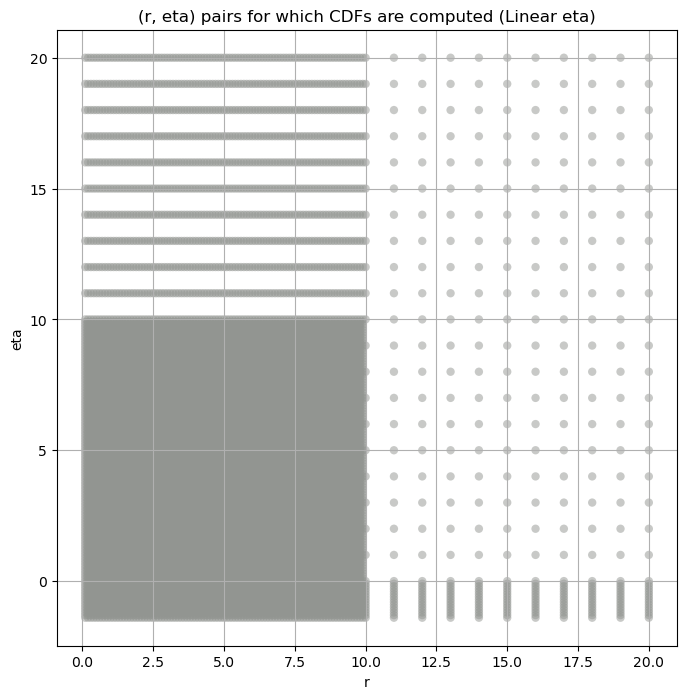

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 10


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var      var_lower      var_upper   obs_kurt  kurt_lower  \
layer                                                                       
2      181299.020000  101527.920000  290782.220000   377.2548   142.30005   
3       38790.293000   21575.710000   67724.600000   543.3528   122.41325   
4        9777.153000    4939.129400   17951.637000   703.4225   122.04025   
5        1796.309800     838.055700    4289.687500  1421.5957    90.04052   
6         385.143370     175.531220    1132.569200  2320.8230    86.76239   
7         101.085400      41.345040     424.742130  4763.6500    67.00212   
8          34.403240      17.919370      89.392410  1599.7200    74.53908   
9           9.890553       5.271057      25.139685  1503.5704    80.86954   
10          1.437362       0.713616       4.495828  2671.0093    76.31533   

       kurt_upper  total_samples  
layer                             
2       530.95166           9000  
3      1044.59230          36000  
4      1327.85640         144000  
5      3420.66140         576000  
6      4401.83100        2304000  
7      6338.22100        9216000  
8      3571.94240       36864000  
9      3415.08840      147456000  
10     4559.32400      589824000

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                 
2      181299.020000  181299.015625    53445.132812    45005.015625   
3       38790.293000   38790.292969    16658.701172    13901.427734   
4        9777.153000    9777.153320     5205.436035     4225.315918   
5        1796.309800    1796.309814      877.923462      739.454651   
6         385.143370     385.143372      184.442383      155.673752   
7         101.085400     101.085403       43.044163       37.106823   
8          34.403240      34.403240       18.637098       15.867031   
9           9.890553       9.890553        5.497751        4.641548   
10          1.437362       1.437362        0.750728        0.638910   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2        39764.375000     35826.558594     29935.412109     25676.896484   
3        12450.913086     11435.818359     10024.355469      9036.393555   
4         3701.995605      3371.860596      2965.561035      2685.450684   
5          660.926331       608.932739       539.697815       493.000732   
6          139.585052       128.891220       114.931679       105.546707   
7           33.802219        31.588554        28.653296        26.686485   
8           14.410744        13.485414        12.335011        11.598041   
9            4.199530         3.923208         3.575012         3.345420   
10           0.579036         0.540092         0.489522         0.455763   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2         22347.351562     19796.291016     17737.582031     13339.328125  
3          8276.482422      7653.456055      7134.823242      5996.537109  
4          2475.111572      2312.414307      2181.538330      1889.148071  
5           457.898407       429.701477       406.275940       353.606781  
6            98.497536        92.854347        88.198059        77.910538  
7            25.226971        24.069933        23.112175        20.952991  
8            11.049903        10.608747        10.236945         9.369852  
9             3.171578         3.030438         2.910954         2.631608  
10            0.430242         0.409593         0.392173         0.351724

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.024957792983662186 181299.02


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.013862231720138007 53445.133


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.01379296714770939 45005.016


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.014657245566810362 39764.375


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.016401008366089598 35826.56


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.021568632706036702 29935.412


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.026885084165086087 25676.896


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.03277832359404194 22347.352


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.037925959777317886 19796.291


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.04361088374817648 17737.582


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.058570773140779034 13339.328
Number of samples: 9000, Without approximation : 9000


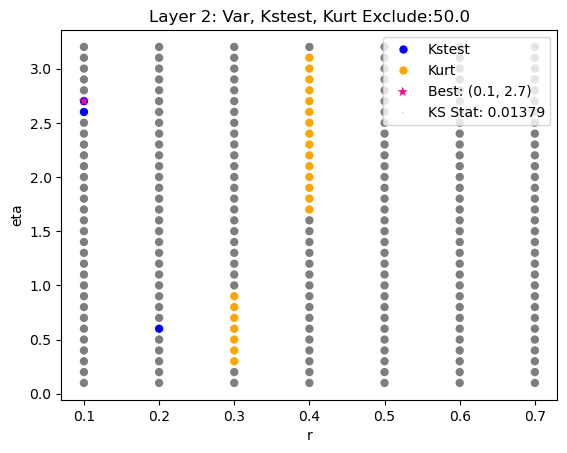

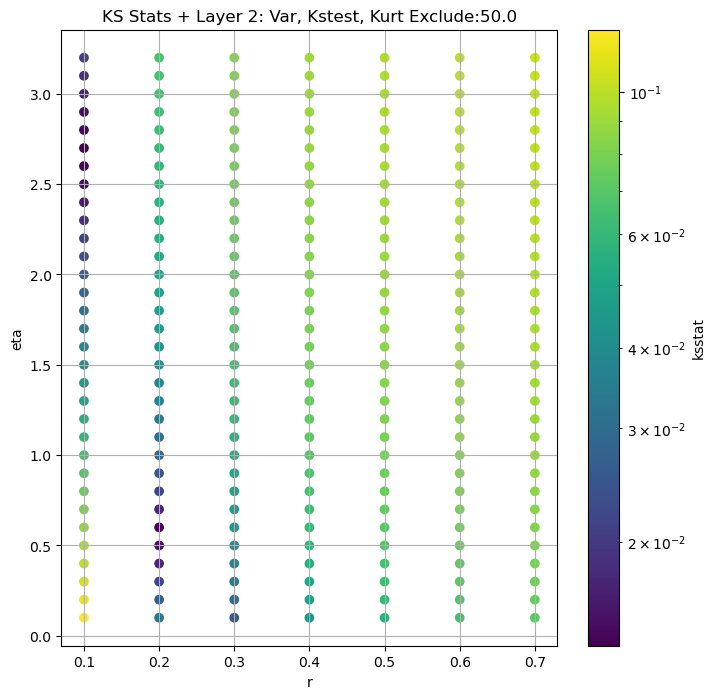

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.028425924524568935 38790.293


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.014267306869617746 16658.701


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.010459129318967753 13901.428


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.009516468312032178 12450.913


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.009469242407850076 11435.818


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.009005929363847032 10024.355


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.010022594332383152 9036.394


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.01139613570067274 8276.482


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.012634129000670086 7653.456


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.01421309094061424 7134.823


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.01841725640290258 5996.537
Number of samples: 36000, Without approximation : 36000


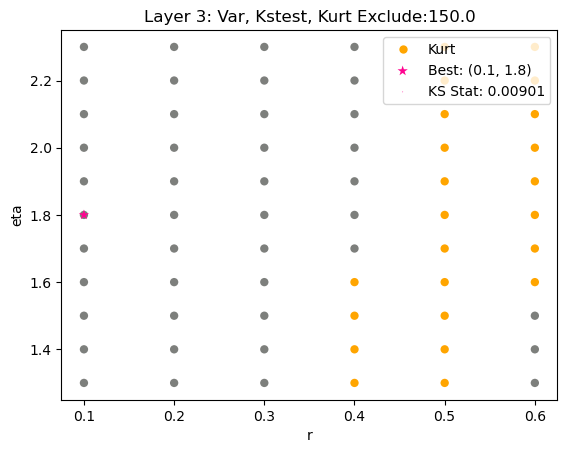

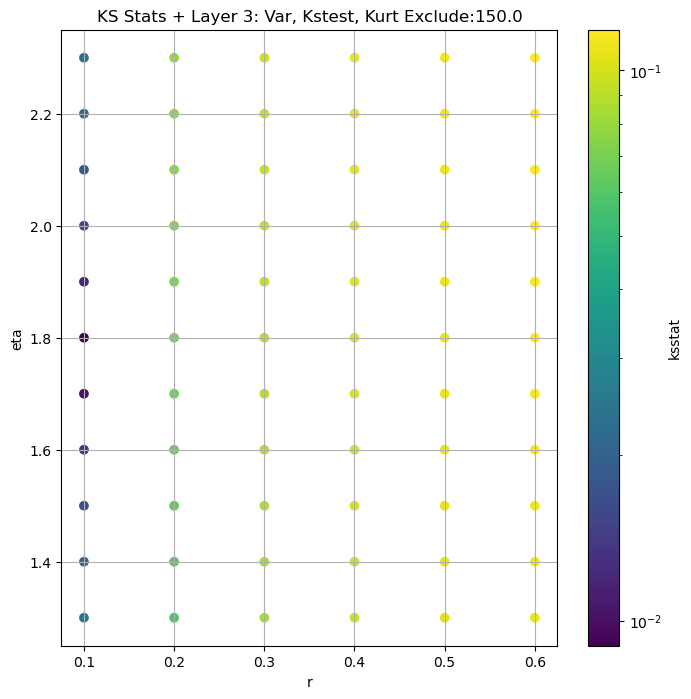

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.03445476587157836 9777.153


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.022668599506869946 5205.436


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.019084982190605393 4225.316


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.016612427801005136 3701.9956


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.015463537751488565 3371.8606


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.011859486857412227 2965.561


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.011538441489205242 2685.4507


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.008978385313621606 2475.1116


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.007667893351642752 2312.4143


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.0070046289742188295 2181.5383


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.008767831401623516 1889.1481
Number of samples: 100000, Without approximation : 144000


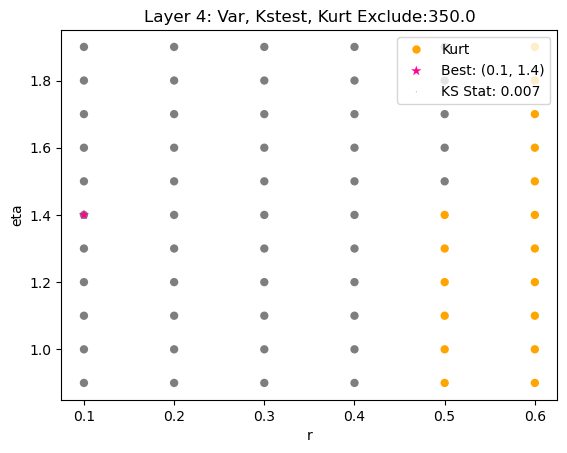

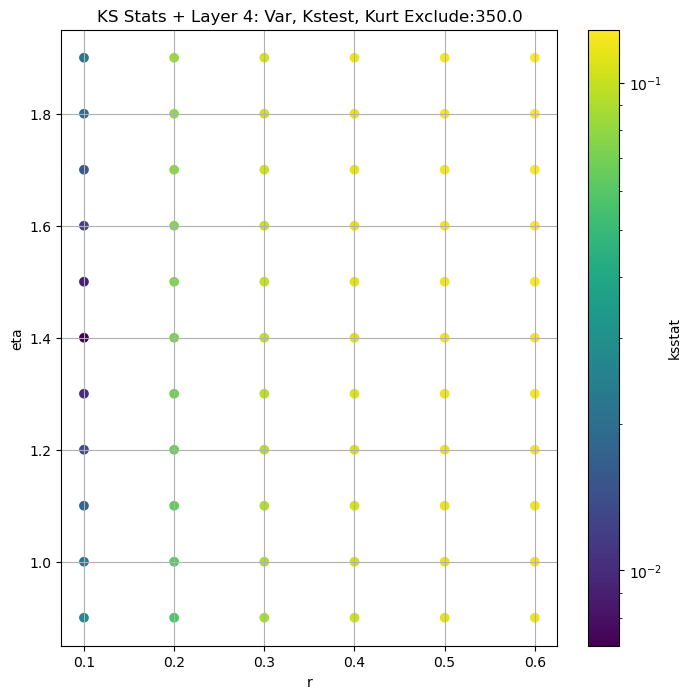

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.033598889507328644 1796.3098


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.01917547127905317 877.92346


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.016154192608701434 739.45465


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.015240712925992939 660.92633


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.013468230259246927 608.93274


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.011427569282368766 539.6978


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.008429784539115581 493.00073


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.008005000363107917 457.8984


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.0059047689993557695 429.70148


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.006169633530681451 406.27594


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.007967809599247477 353.60678
Number of samples: 100000, Without approximation : 576000


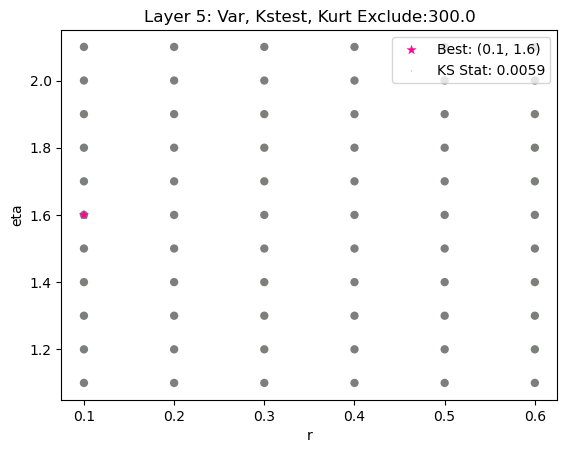

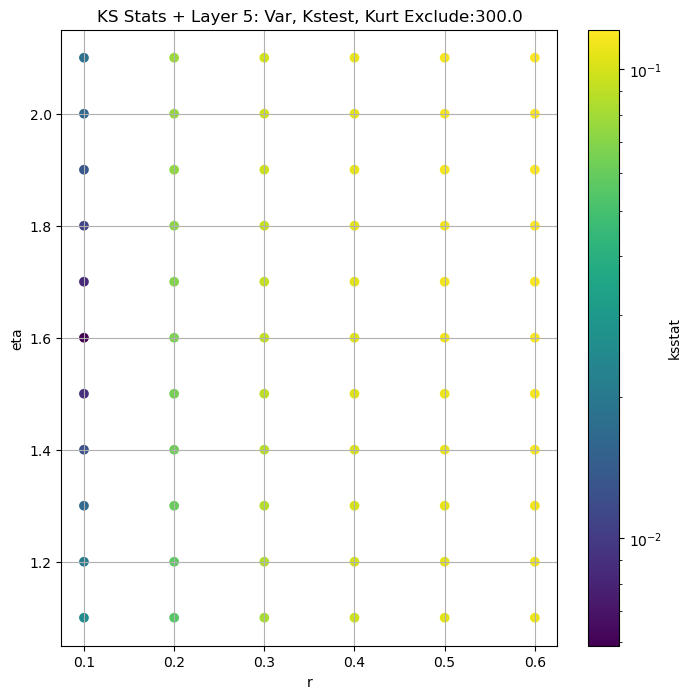

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.03143031176208677 385.14337


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.0190210069984017 184.44238


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.014078828909580232 155.67375


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.01171916748355506 139.58505


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.010535787082792125 128.89122


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.008397976171020338 114.93168


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.005973900948685995 105.54671


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.004297702104541723 98.497536


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.0048190809382431254 92.85435


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.0054373420924209714 88.19806


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.007079016582131503 77.91054
Number of samples: 100000, Without approximation : 2304000


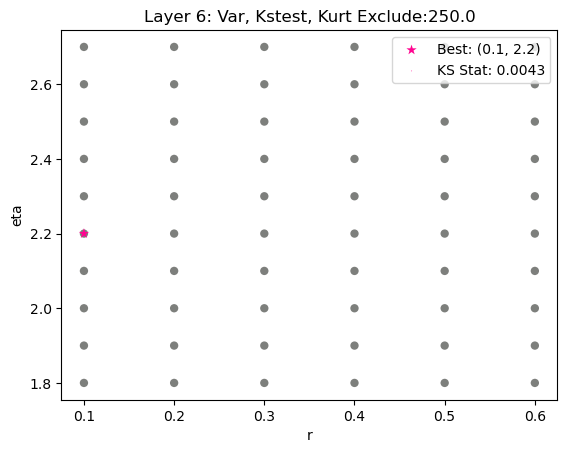

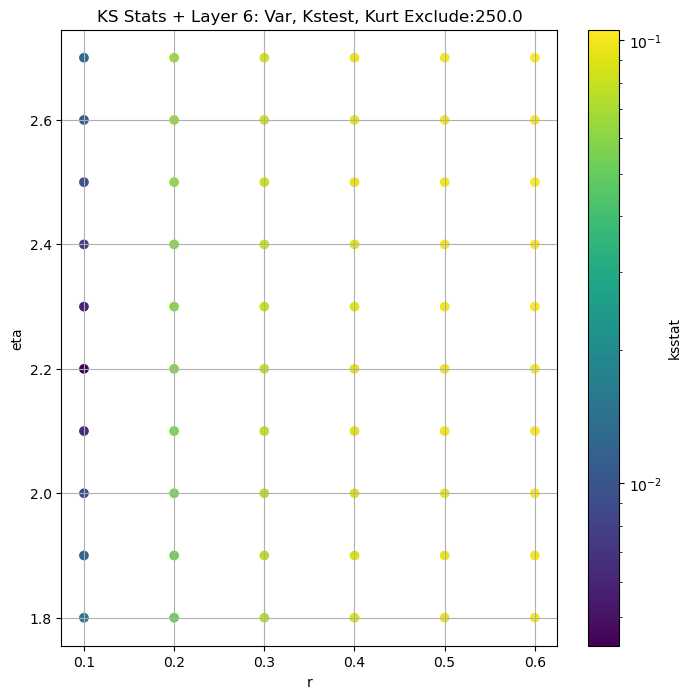

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.03179690238159949 101.0854


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.01286083677409644 43.044163


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.009295368754298428 37.106823


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.006956013669048522 33.80222


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.0051041730403912355 31.588554


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.0030623937503934107 28.653296


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.003074162424301141 26.686485


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.0037422148139699685 25.22697


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.0043780882059297754 24.069933


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.004937497957685444 23.112175


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.006767160330317323 20.952991
Number of samples: 100000, Without approximation : 9216000


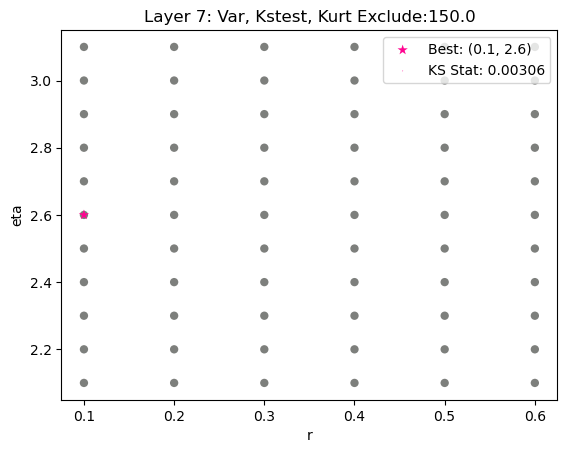

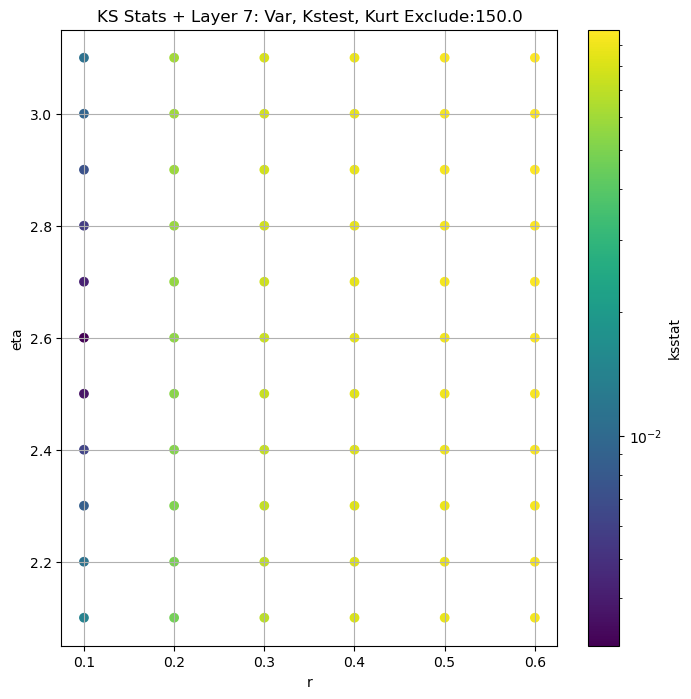

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.02293786008932963 34.40324


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.009525221658700928 18.637098


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.006447016037462339 15.867031


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.00368851696299001 14.410744


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.0025042915722614523 13.485414


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.002743501930765224 12.3350115


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.0034044694175645596 11.598041


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.004067732238324462 11.049903


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.005001327811190115 10.6087475


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.005616208409128687 10.236945


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.0074339427002534375 9.369852
Number of samples: 100000, Without approximation : 36864000


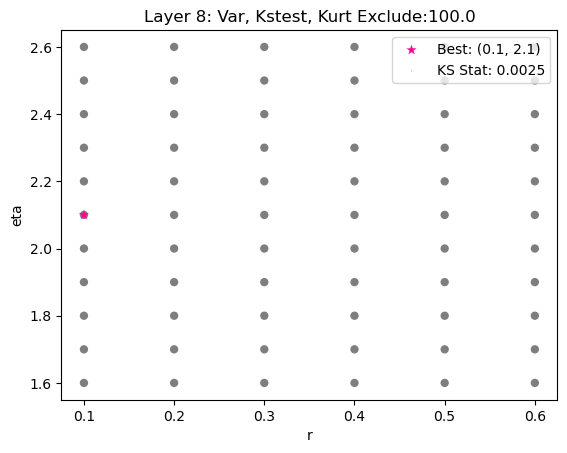

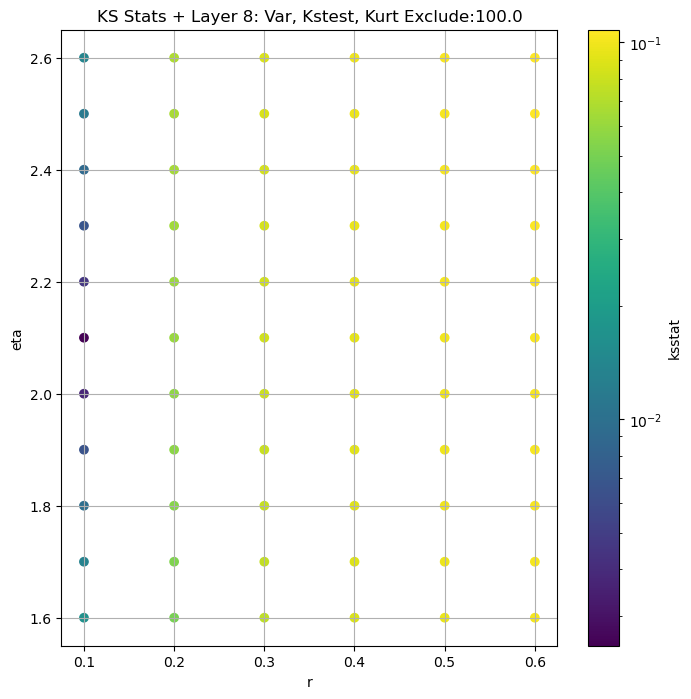

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.024406736660055356 9.8905525


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.013449278004063592 5.497751


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.009081230055069889 4.6415477


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.006805737885956509 4.1995296


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.006758430252645886 3.923208


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.004689696394846676 3.5750124


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.004429446248820801 3.3454201


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.004834690112017537 3.1715782


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.005730814241737936 3.0304377


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.006139101487050547 2.9109538


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.007881848818921178 2.6316082
Number of samples: 100000, Without approximation : 147456000


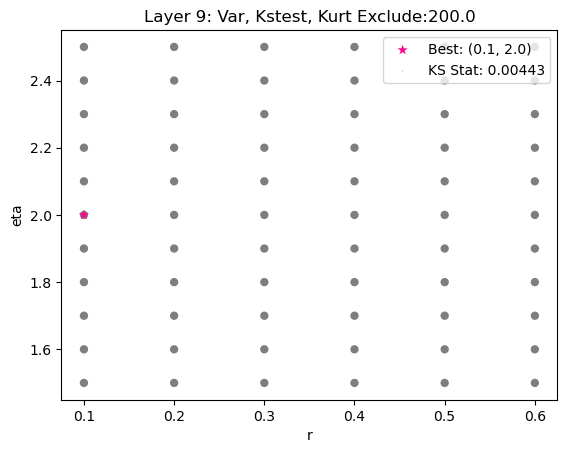

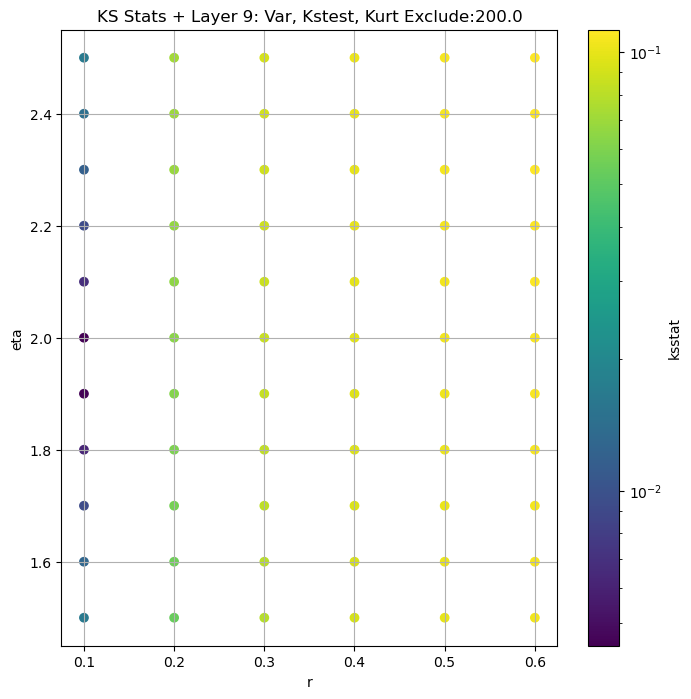

####
Layer  10


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 0 0.028145978868329258 1.4373621


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 25 0.015702829456101075 0.750728


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 50 0.0132570350376634 0.63890994


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 75 0.010882224965640175 0.5790363


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 100 0.010231918722788724 0.5400915


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 150 0.00848122847271715 0.48952162


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 200 0.006147324336817639 0.4557626


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 250 0.006170648601177331 0.43024194


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 300 0.006415443998396962 0.40959314


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 350 0.006604420013086178 0.39217314


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 500 0.00839134547859963 0.35172412
Number of samples: 100000, Without approximation : 589824000


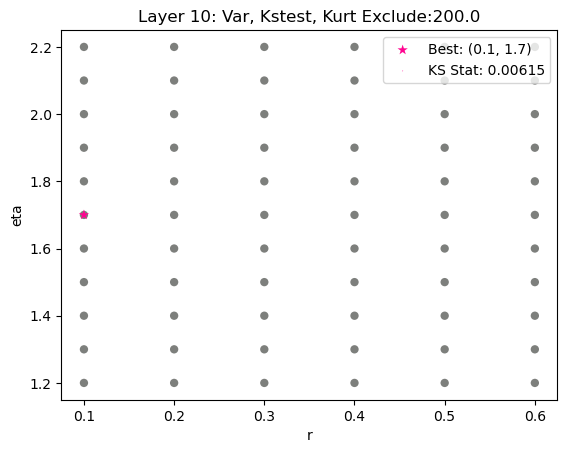

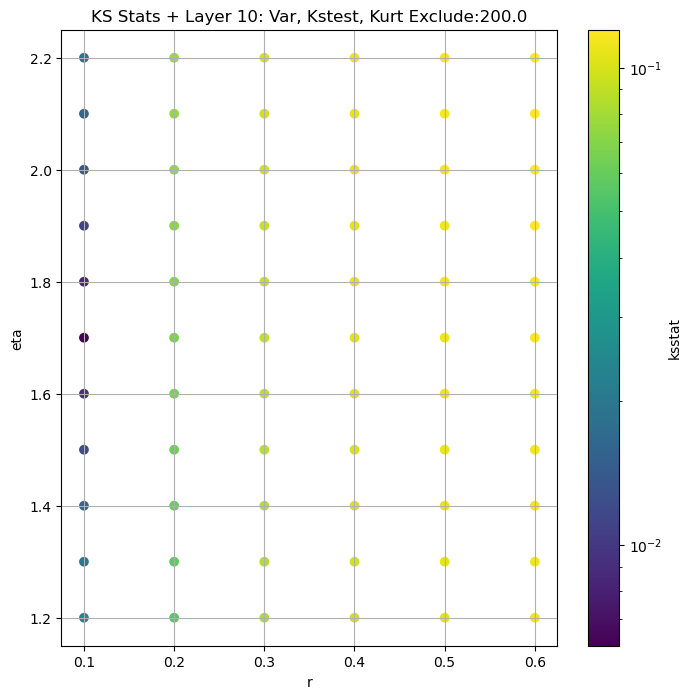

obs_var      var_lower      var_upper   obs_kurt  kurt_lower  \
layer                                                                       
2      181299.020000  101527.920000  290782.220000   377.2548   142.30005   
3       38790.293000   21575.710000   67724.600000   543.3528   122.41325   
4        9777.153000    4939.129400   17951.637000   703.4225   122.04025   
5        1796.309800     838.055700    4289.687500  1421.5957    90.04052   
6         385.143370     175.531220    1132.569200  2320.8230    86.76239   
7         101.085400      41.345040     424.742130  4763.6500    67.00212   
8          34.403240      17.919370      89.392410  1599.7200    74.53908   
9           9.890553       5.271057      25.139685  1503.5704    80.86954   
10          1.437362       0.713616       4.495828  2671.0093    76.31533   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       530.95166           9000             0.013793        0.1          2.7   
3      1044.59230          36000             0.009006        0.1          1.8   
4      1327.85640         144000             0.007005        0.1          1.4   
5      3420.66140         576000             0.005905        0.1          1.6   
6      4401.83100        2304000             0.004298        0.1          2.2   
7      6338.22100        9216000             0.003062        0.1          2.6   
8      3571.94240       36864000             0.002504        0.1          2.1   
9      3415.08840      147456000             0.004429        0.1          2.0   
10     4559.32400      589824000             0.006147        0.1          1.7   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       9.706101e-13                    50.0        45005.016000   
3       1.877371e-12                   150.0        10024.355000   
4       1.271696e-12                   350.0         2181.538300   
5       1.396953e-13                   300.0          429.701480   
6       6.658721e-15                   250.0           98.497536   
7       7.686786e-16                   150.0           28.653296   
8       1.164890e-15                   100.0           13.485414   
9       3.715489e-16                   200.0            3.345420   
10      1.120293e-16                   200.0            0.455763   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.014297  
3                     0.007153  
4                     0.003578  
5                     0.001789  
6                     0.000895  
7                     0.000447  
8                     0.000224  
9                     0.000112  
10                    0.000056

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 2, 50.0 + 100 = 150, ksstat: 0.02453884216067132, var: 29935.412109375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 2, 50.0 + 75 = 125, ksstat: 0.021679528341171046, var: 32620.796875


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 2, 50.0 + 50 = 100, ksstat: 0.018725589877029165, var: 35826.55859375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 2, 50.0 + 25 = 75, ksstat: 0.015721370913069063, var: 39764.375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 2, 50.0 + 0 = 50, ksstat: 0.01379296714770939, var: 45005.015625


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 2, 50.0 + -25 = 25, ksstat: 0.013862231720138007, var: 53445.1328125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 2, 50.0 + -50 = 0, ksstat: 0.025856872516427987, var: 181299.015625
Number of samples: 9000, Without approximation : 9000


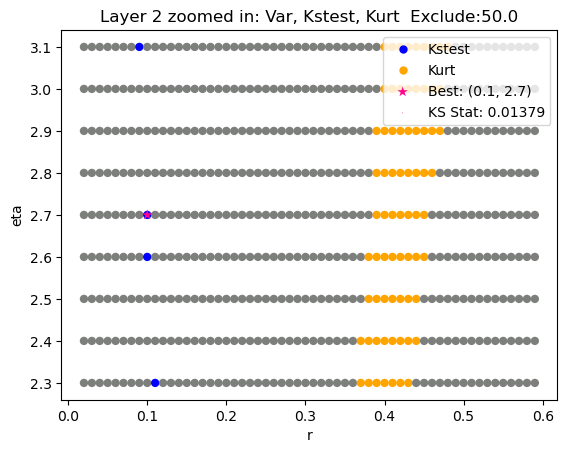

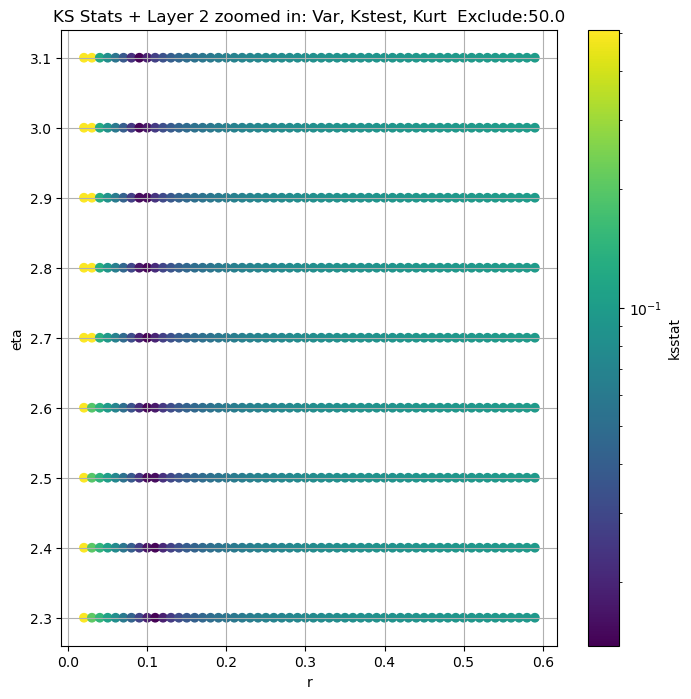

Layer 3


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 3, 150.0 + 100 = 250, ksstat: 0.012566386841601652, var: 8276.482421875


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 3, 150.0 + 75 = 225, ksstat: 0.011743627653549377, var: 8635.9638671875


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 3, 150.0 + 50 = 200, ksstat: 0.010701316438742118, var: 9036.3935546875


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 3, 150.0 + 25 = 175, ksstat: 0.00974687602282458, var: 9488.7685546875


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 3, 150.0 + 0 = 150, ksstat: 0.009005929363847032, var: 10024.35546875


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 3, 150.0 + -25 = 125, ksstat: 0.00876565091864201, var: 10663.84765625


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 3, 150.0 + -50 = 100, ksstat: 0.009062864873722265, var: 11435.818359375


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 3, 150.0 + -75 = 75, ksstat: 0.009516468312032178, var: 12450.9130859375


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 3, 150.0 + -100 = 50, ksstat: 0.010704987304500091, var: 13901.427734375
Number of samples: 36000, Without approximation : 36000


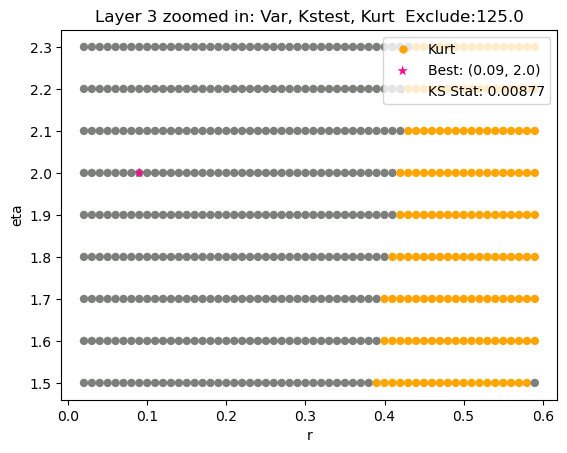

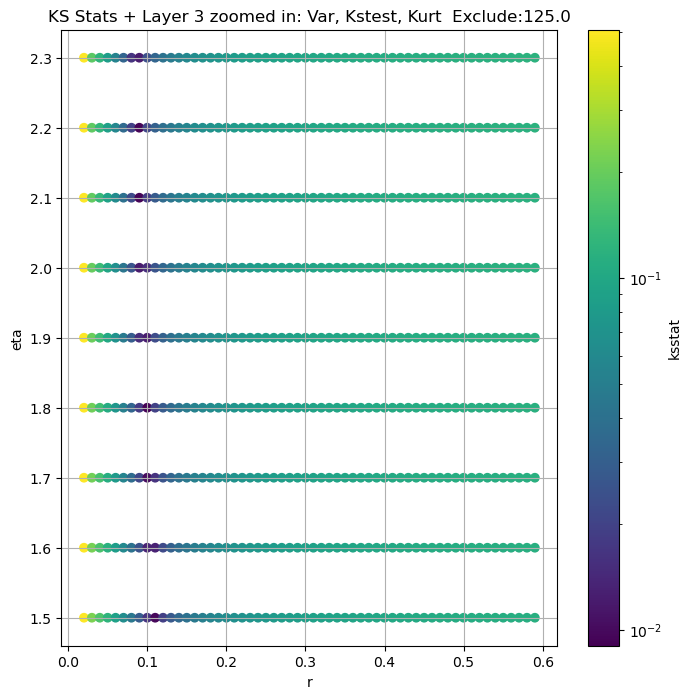

Layer 4


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 4, 350.0 + 100 = 450, ksstat: 0.008025285014543027, var: 1974.5982666015625


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 4, 350.0 + 75 = 425, ksstat: 0.007682006892306997, var: 2021.60009765625


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 4, 350.0 + 50 = 400, ksstat: 0.007264212441912998, var: 2071.40234375


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 4, 350.0 + 25 = 375, ksstat: 0.0069512630673809195, var: 2124.435302734375


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 4, 350.0 + 0 = 350, ksstat: 0.006980924463103277, var: 2181.538330078125


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 4, 350.0 + -25 = 325, ksstat: 0.0067817141130445124, var: 2243.47705078125


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 4, 350.0 + -50 = 300, ksstat: 0.007667893351642752, var: 2312.414306640625


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 4, 350.0 + -75 = 275, ksstat: 0.007967345595773612, var: 2388.10888671875


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 4, 350.0 + -100 = 250, ksstat: 0.008495705757304073, var: 2475.111572265625
Number of samples: 100000, Without approximation : 144000


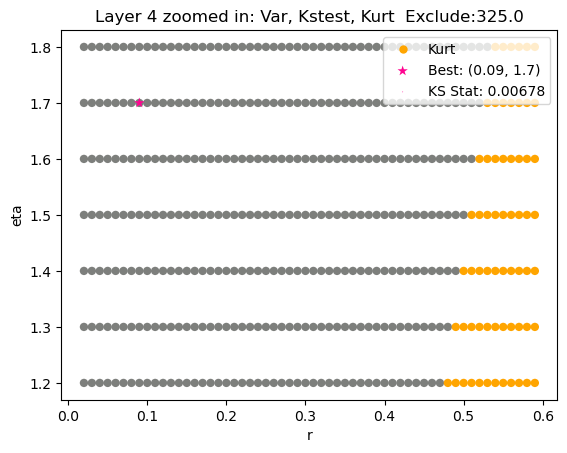

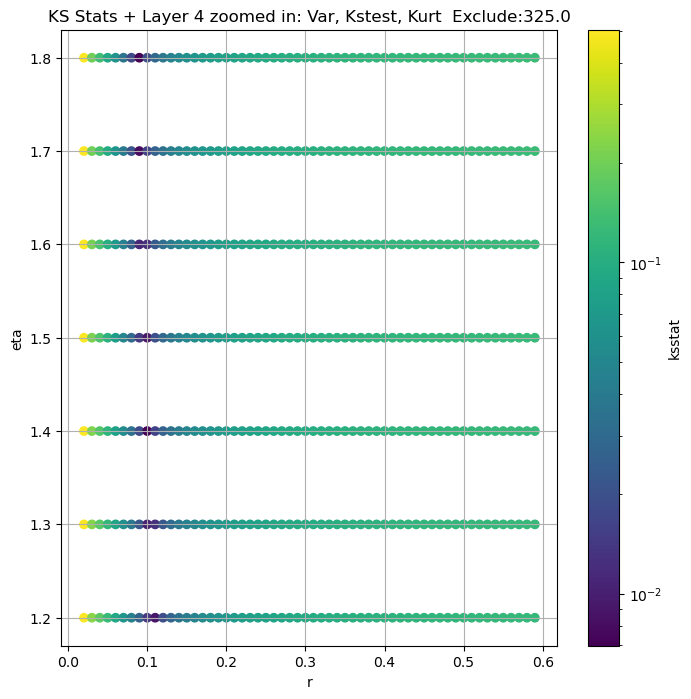

Layer 5


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 300.0 + 100 = 400, ksstat: 0.006840499119230681, var: 386.3902893066406


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 300.0 + 75 = 375, ksstat: 0.006448836054447682, var: 395.9581298828125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 300.0 + 50 = 350, ksstat: 0.006116290244931544, var: 406.27593994140625


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 300.0 + 25 = 325, ksstat: 0.0059360317783729855, var: 417.48431396484375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 300.0 + 0 = 300, ksstat: 0.0059047689993557695, var: 429.70147705078125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 300.0 + -25 = 275, ksstat: 0.006229954356214651, var: 443.09381103515625


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 300.0 + -50 = 250, ksstat: 0.006757126906912991, var: 457.8984069824219


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 300.0 + -75 = 225, ksstat: 0.008009564371885158, var: 474.3857421875


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 300.0 + -100 = 200, ksstat: 0.008429784539115581, var: 493.000732421875
Number of samples: 100000, Without approximation : 576000


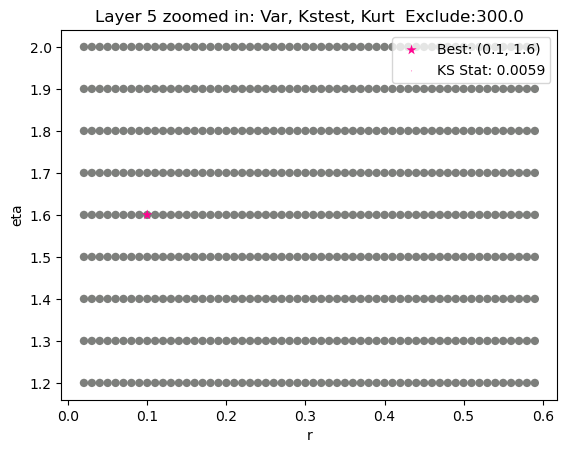

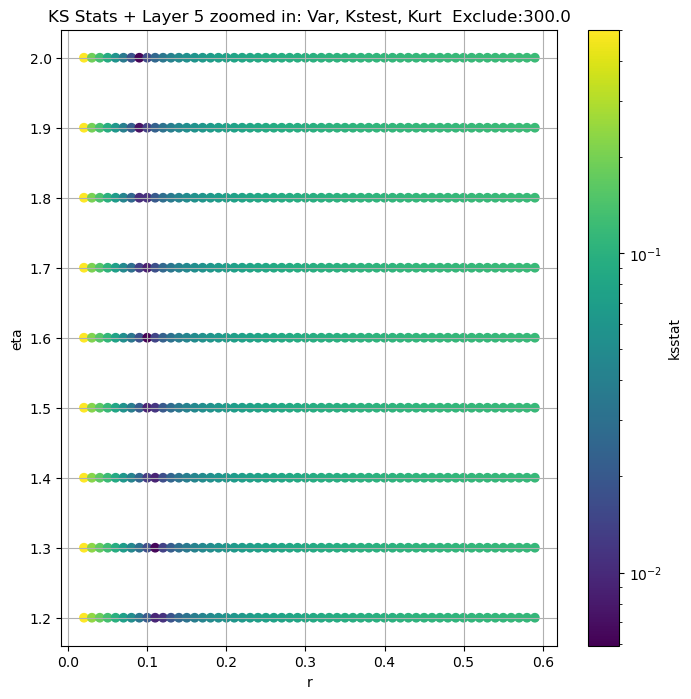

Layer 6


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 250.0 + 100 = 350, ksstat: 0.005410439032099257, var: 88.19805908203125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 250.0 + 75 = 325, ksstat: 0.005075173037623393, var: 90.42097473144531


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 250.0 + 50 = 300, ksstat: 0.004794641114463261, var: 92.8543472290039


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 250.0 + 25 = 275, ksstat: 0.00443705531177474, var: 95.53387451171875


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 250.0 + 0 = 250, ksstat: 0.004297702104541723, var: 98.4975357055664


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 250.0 + -25 = 225, ksstat: 0.004692754486213591, var: 101.79994201660156


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 250.0 + -50 = 200, ksstat: 0.0054330562871814925, var: 105.54670715332031


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 250.0 + -75 = 175, ksstat: 0.006670352984268435, var: 109.86846160888672


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 250.0 + -100 = 150, ksstat: 0.007157930604846208, var: 114.93167877197266
Number of samples: 100000, Without approximation : 2304000


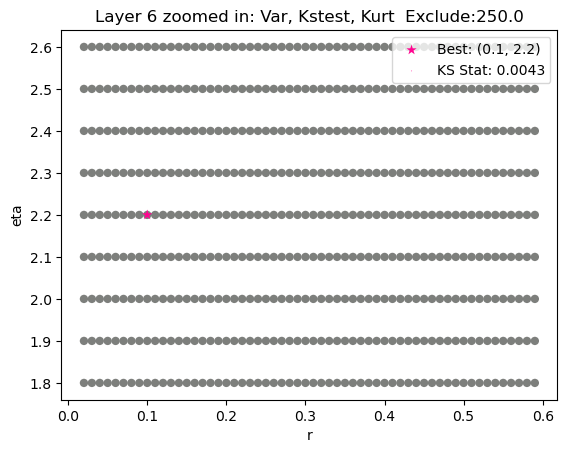

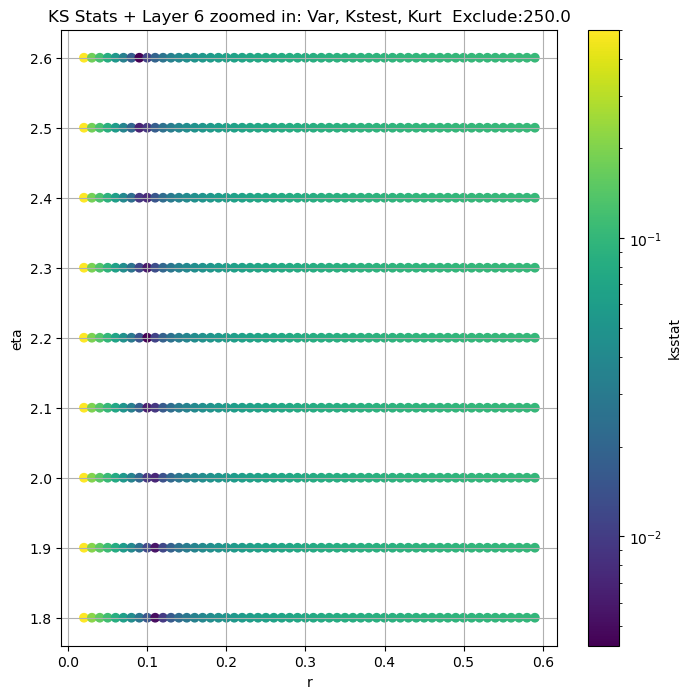

Layer 7


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 150.0 + 100 = 250, ksstat: 0.0037041596268619914, var: 25.226970672607422


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 150.0 + 75 = 225, ksstat: 0.003394056406871848, var: 25.909584045410156


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 150.0 + 50 = 200, ksstat: 0.003074162424301141, var: 26.686485290527344


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 150.0 + 25 = 175, ksstat: 0.0027671138777638493, var: 27.586803436279297


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 150.0 + 0 = 150, ksstat: 0.0029488414159533627, var: 28.653295516967773


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 150.0 + -25 = 125, ksstat: 0.0038937987780939265, var: 29.950611114501953


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 150.0 + -50 = 100, ksstat: 0.0051041730403912355, var: 31.58855438232422


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 150.0 + -75 = 75, ksstat: 0.006307765463493875, var: 33.80221939086914


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 150.0 + -100 = 50, ksstat: 0.00849345833660553, var: 37.1068229675293
Number of samples: 100000, Without approximation : 9216000


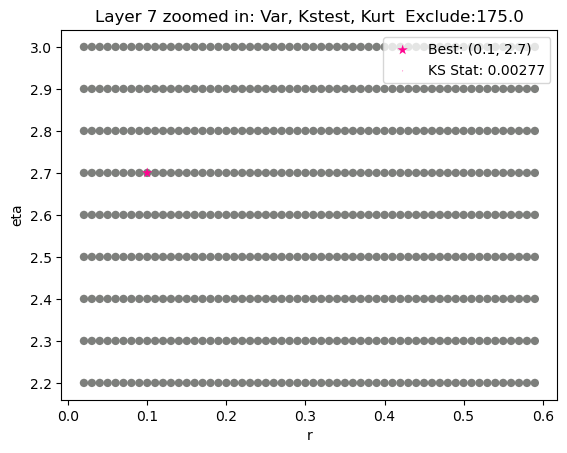

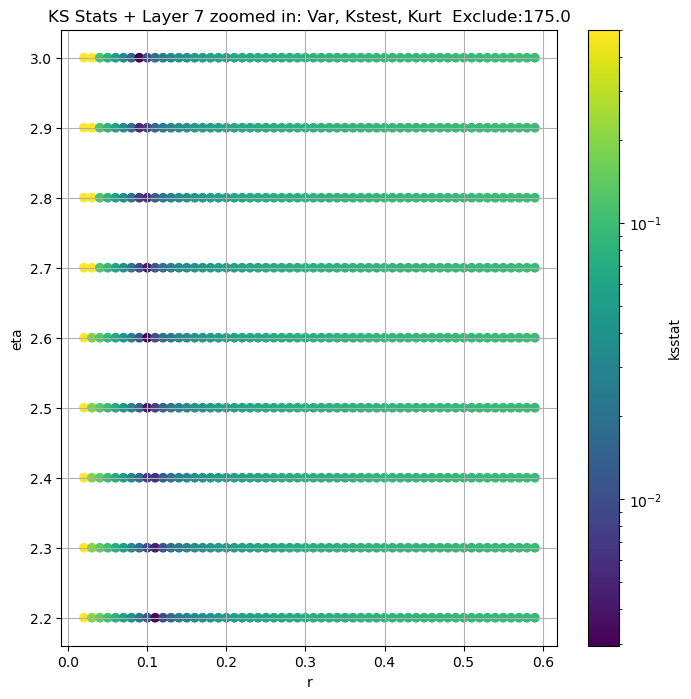

Layer 8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 100.0 + 100 = 200, ksstat: 0.003872629163175434, var: 11.598040580749512


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 100.0 + 75 = 175, ksstat: 0.0032357192918975874, var: 11.934507369995117


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 100.0 + 50 = 150, ksstat: 0.002598743098473355, var: 12.33501148223877


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 100.0 + 25 = 125, ksstat: 0.0023712114782054594, var: 12.831836700439453


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 100.0 + 0 = 100, ksstat: 0.0023399337425851208, var: 13.485413551330566


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 100.0 + -25 = 75, ksstat: 0.003296804535346781, var: 14.410743713378906


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 100.0 + -50 = 50, ksstat: 0.005142759391490892, var: 15.86703109741211


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 100.0 + -75 = 25, ksstat: 0.009276501414071797, var: 18.63709831237793


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 100.0 + -100 = 0, ksstat: 0.020218818856791193, var: 34.40324020385742
Number of samples: 100000, Without approximation : 36864000


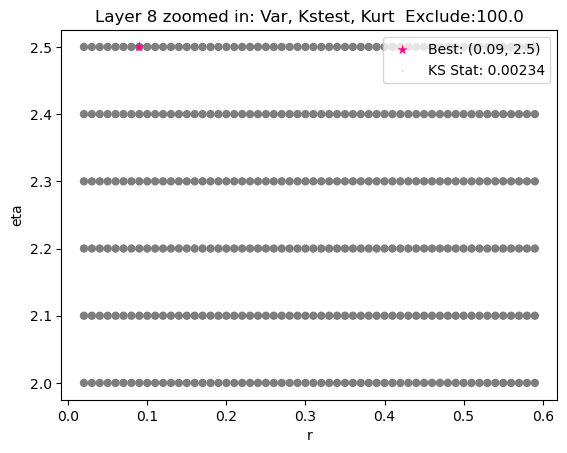

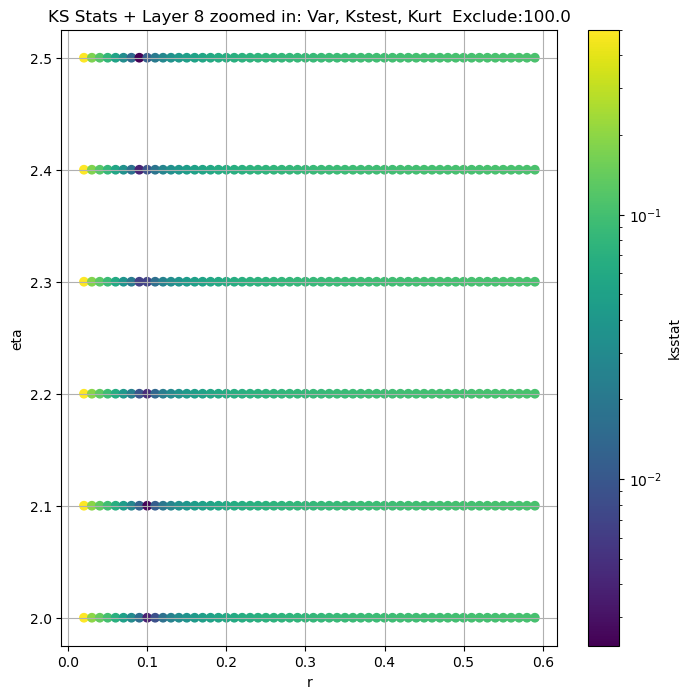

Layer 9


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + 100 = 300, ksstat: 0.006193681181883903, var: 3.030437707901001


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + 75 = 275, ksstat: 0.005761544684355302, var: 3.0977632999420166


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + 50 = 250, ksstat: 0.005383223016636185, var: 3.1715781688690186


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + 25 = 225, ksstat: 0.004905553869669066, var: 3.2534005641937256


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + 0 = 200, ksstat: 0.004392367414819853, var: 3.3454201221466064


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + -25 = 175, ksstat: 0.004008845341671452, var: 3.450859785079956


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + -50 = 150, ksstat: 0.004534110577763428, var: 3.575012445449829


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + -75 = 125, ksstat: 0.005234113412103558, var: 3.7268640995025635


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + -100 = 100, ksstat: 0.005398186211485134, var: 3.923207998275757
Number of samples: 100000, Without approximation : 147456000


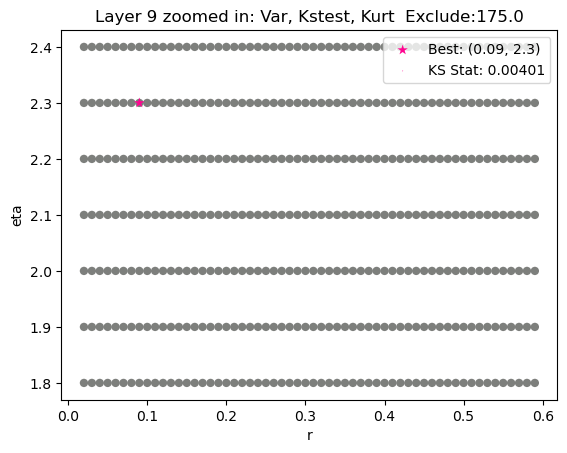

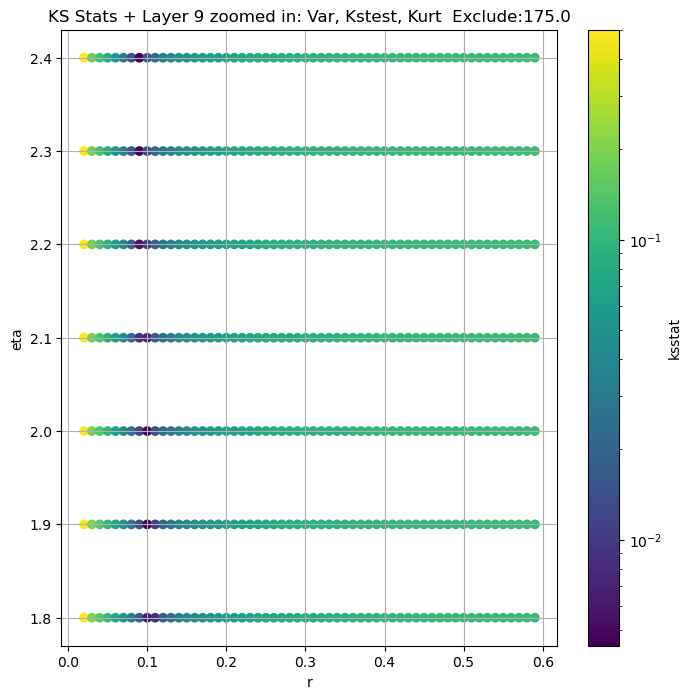

Layer 10


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 200.0 + 100 = 300, ksstat: 0.006246798361506253, var: 0.4095931351184845


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 200.0 + 75 = 275, ksstat: 0.005831167229332419, var: 0.4194350242614746


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 200.0 + 50 = 250, ksstat: 0.005884859156615463, var: 0.4302419424057007


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 200.0 + 25 = 225, ksstat: 0.006021043335984522, var: 0.4422442317008972


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 200.0 + 0 = 200, ksstat: 0.005881268292265873, var: 0.4557625949382782


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 200.0 + -25 = 175, ksstat: 0.006320732434865417, var: 0.4712718427181244


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 200.0 + -50 = 150, ksstat: 0.00717133760513694, var: 0.4895216226577759


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 200.0 + -75 = 125, ksstat: 0.00786524618121337, var: 0.511733889579773


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 200.0 + -100 = 100, ksstat: 0.00869761507042588, var: 0.5400915145874023
Number of samples: 100000, Without approximation : 589824000


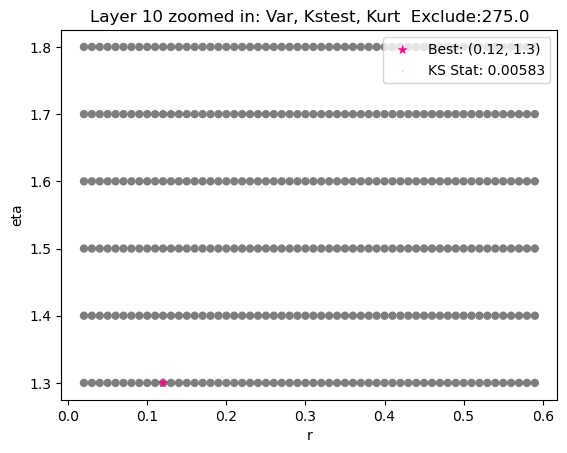

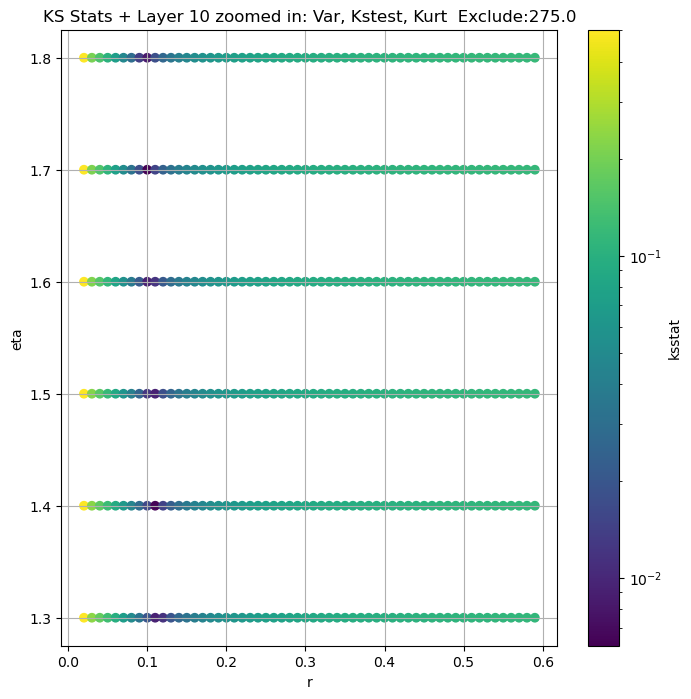

obs_var      var_lower      var_upper   obs_kurt  kurt_lower  \
layer                                                                       
2      181299.020000  101527.920000  290782.220000   377.2548   142.30005   
3       38790.293000   21575.710000   67724.600000   543.3528   122.41325   
4        9777.153000    4939.129400   17951.637000   703.4225   122.04025   
5        1796.309800     838.055700    4289.687500  1421.5957    90.04052   
6         385.143370     175.531220    1132.569200  2320.8230    86.76239   
7         101.085400      41.345040     424.742130  4763.6500    67.00212   
8          34.403240      17.919370      89.392410  1599.7200    74.53908   
9           9.890553       5.271057      25.139685  1503.5704    80.86954   
10          1.437362       0.713616       4.495828  2671.0093    76.31533   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       530.95166           9000             0.013793        0.1          2.7   
3      1044.59230          36000             0.009006        0.1          1.8   
4      1327.85640         144000             0.007005        0.1          1.4   
5      3420.66140         576000             0.005905        0.1          1.6   
6      4401.83100        2304000             0.004298        0.1          2.2   
7      6338.22100        9216000             0.003062        0.1          2.6   
8      3571.94240       36864000             0.002504        0.1          2.1   
9      3415.08840      147456000             0.004429        0.1          2.0   
10     4559.32400      589824000             0.006147        0.1          1.7   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       9.706101e-13                    50.0        45005.016000   
3       1.877371e-12                   150.0        10663.847656   
4       1.271696e-12                   350.0         2243.477051   
5       1.396953e-13                   300.0          429.701480   
6       6.658721e-15                   250.0           98.497536   
7       7.686786e-16                   150.0           27.586803   
8       1.164890e-15                   100.0           13.485414   
9       3.715489e-16                   200.0            3.450860   
10      1.120293e-16                   200.0            0.419435   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.014297          0.013793    0.10       2.7   
3                     0.007153          0.008766    0.09       2.0   
4                     0.003578          0.006782    0.09       1.7   
5                     0.001789          0.005905    0.10       1.6   
6                     0.000895          0.004298    0.10       2.2   
7                     0.000447          0.002767    0.10       2.7   
8                     0.000224          0.002340    0.09       2.5   
9                     0.000112          0.004009    0.09       2.3   
10                    0.000056          0.005831    0.12       1.3   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      9.706101e-13                 50.0        10125  
3      6.112735e-15                125.0        22780  
4      3.105285e-15                325.0        40500  
5      1.396953e-13                300.0        54000  
6      6.658721e-15                250.0       102514  
7      5.949566e-16                175.0       243000  
8      2.046462e-18                100.0       324000  
9      8.743537e-19                175.0       121500  
10     5.115524e-13                275.0        54000

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

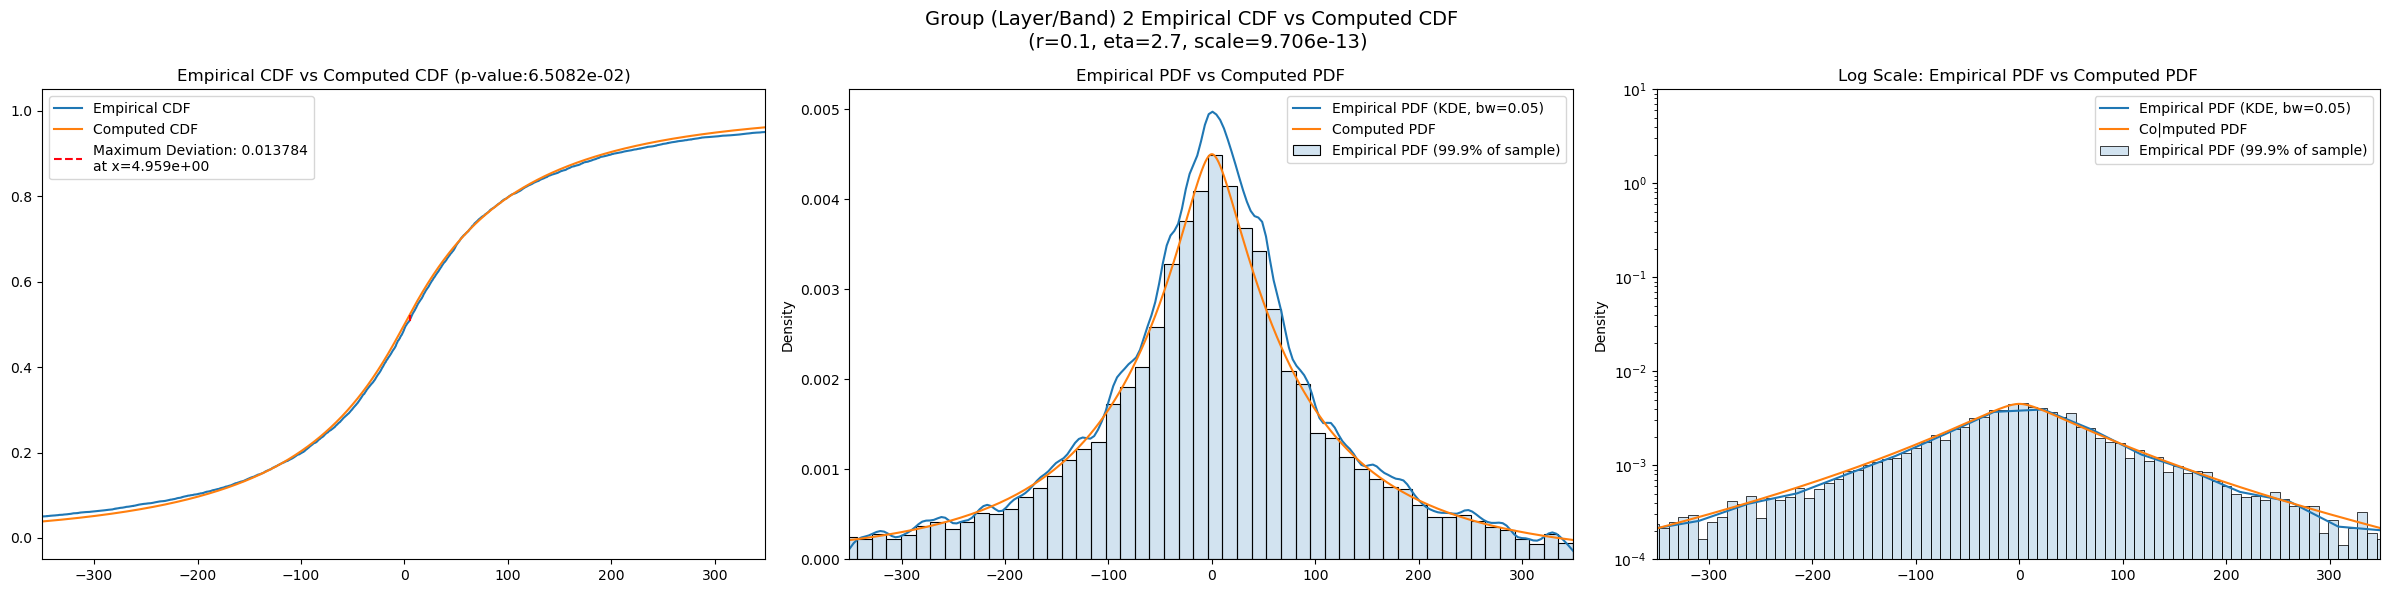

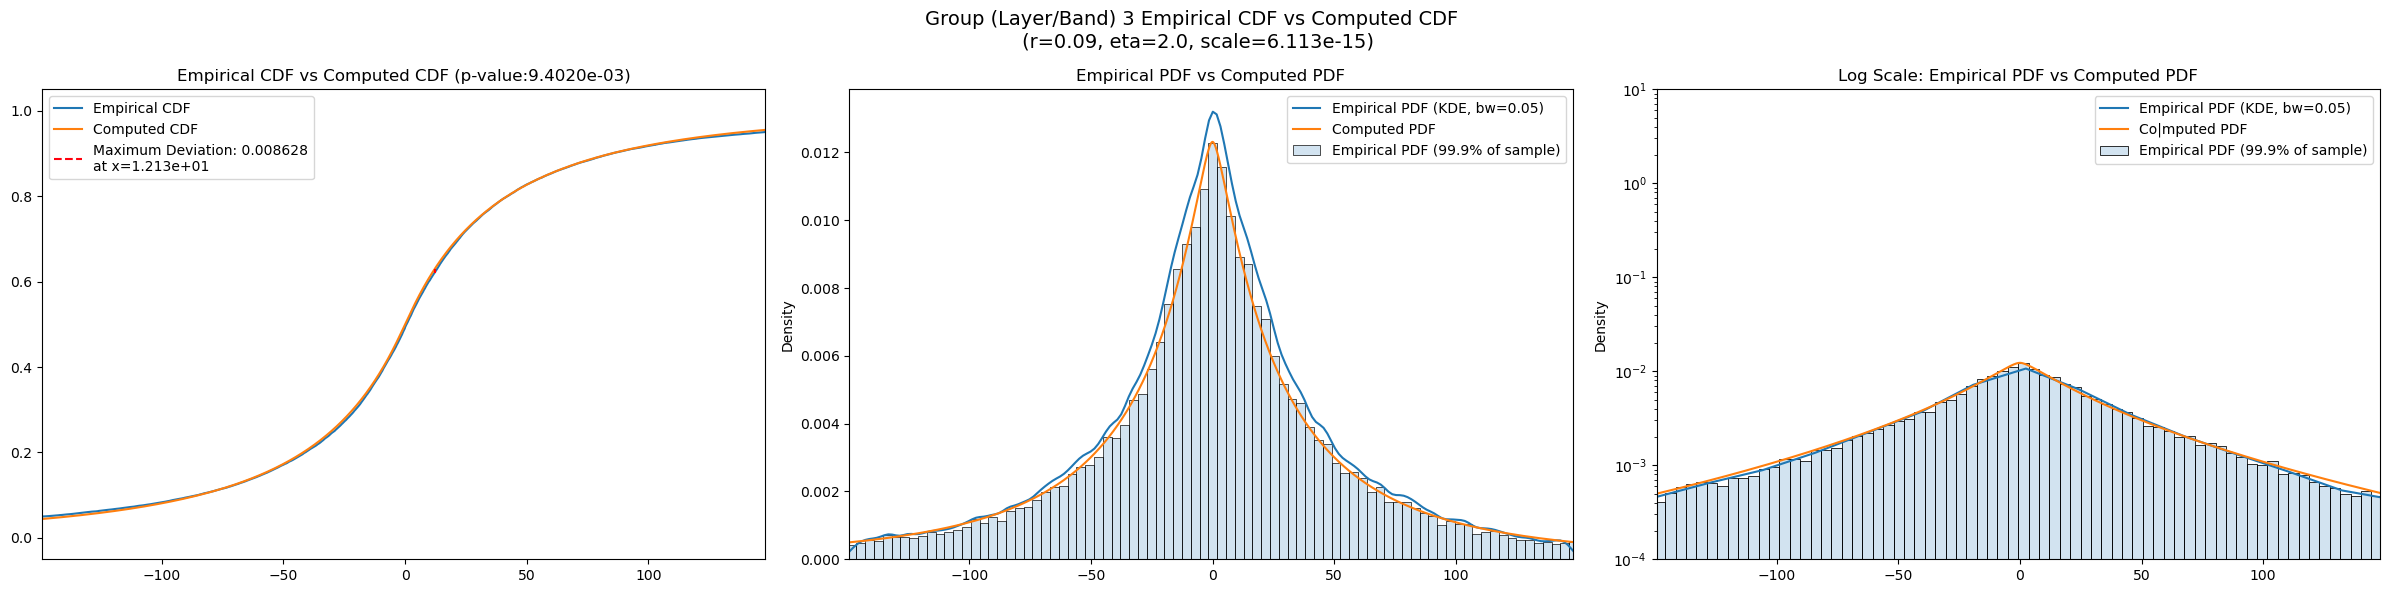

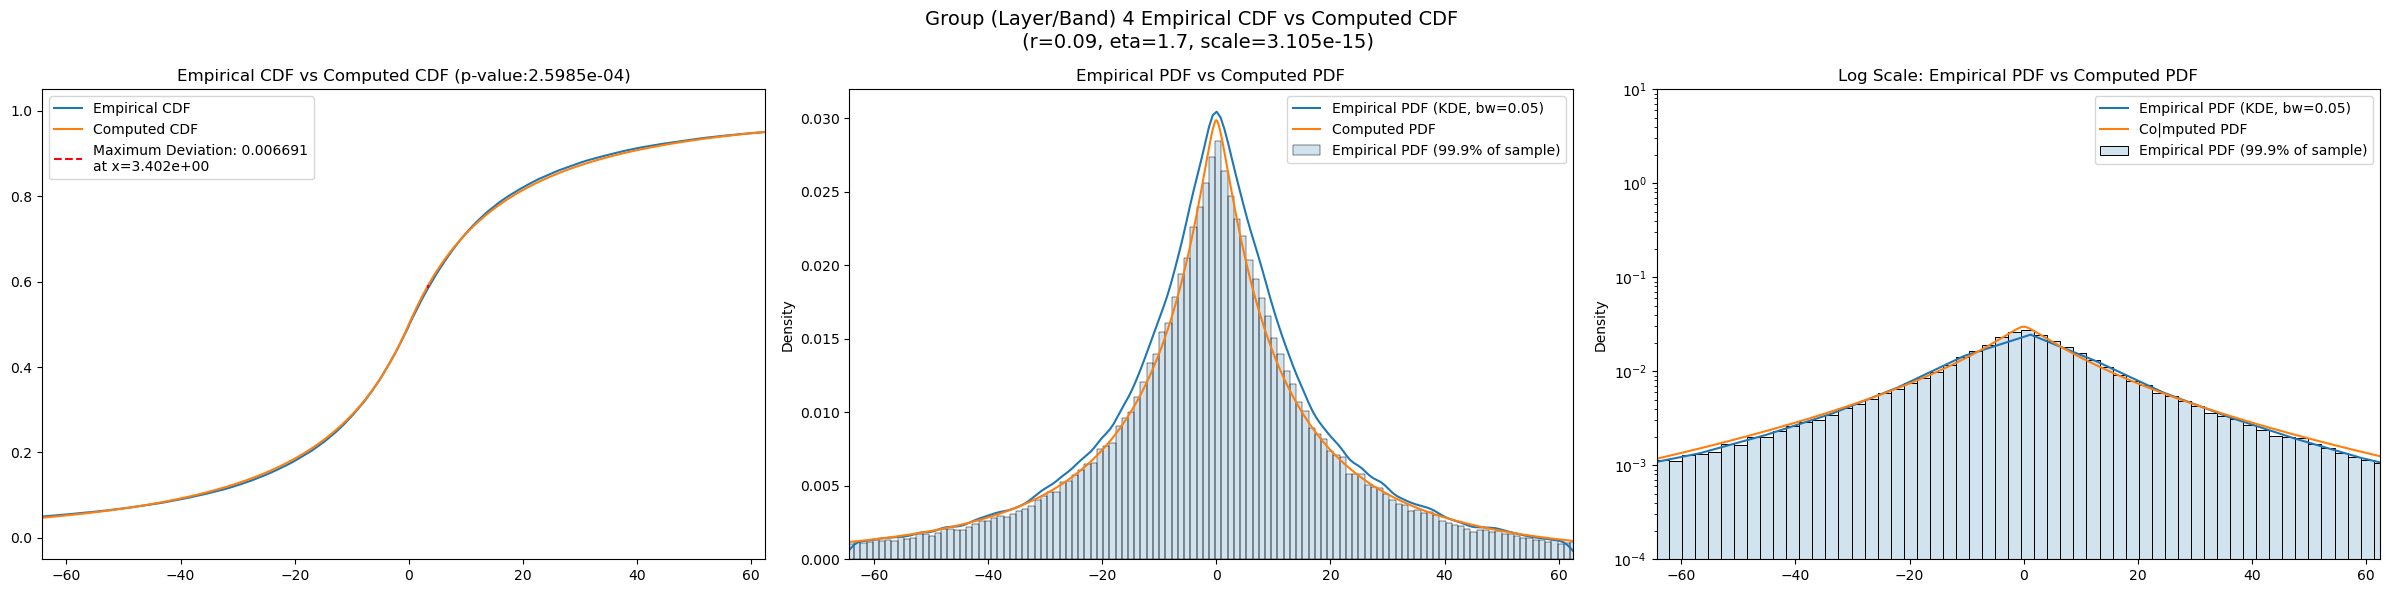

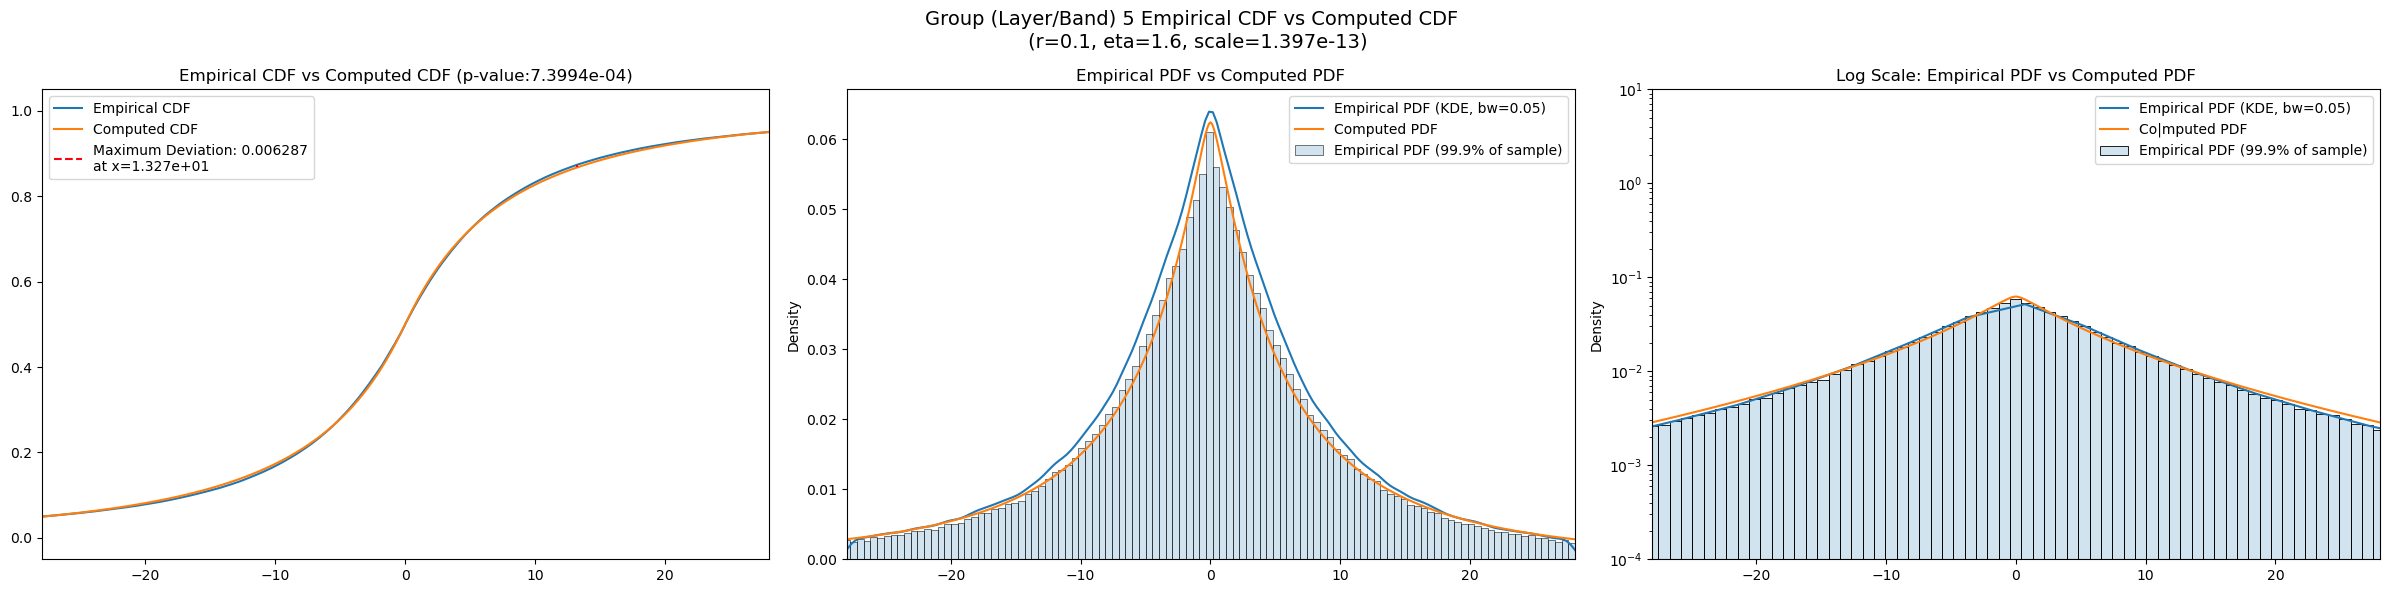

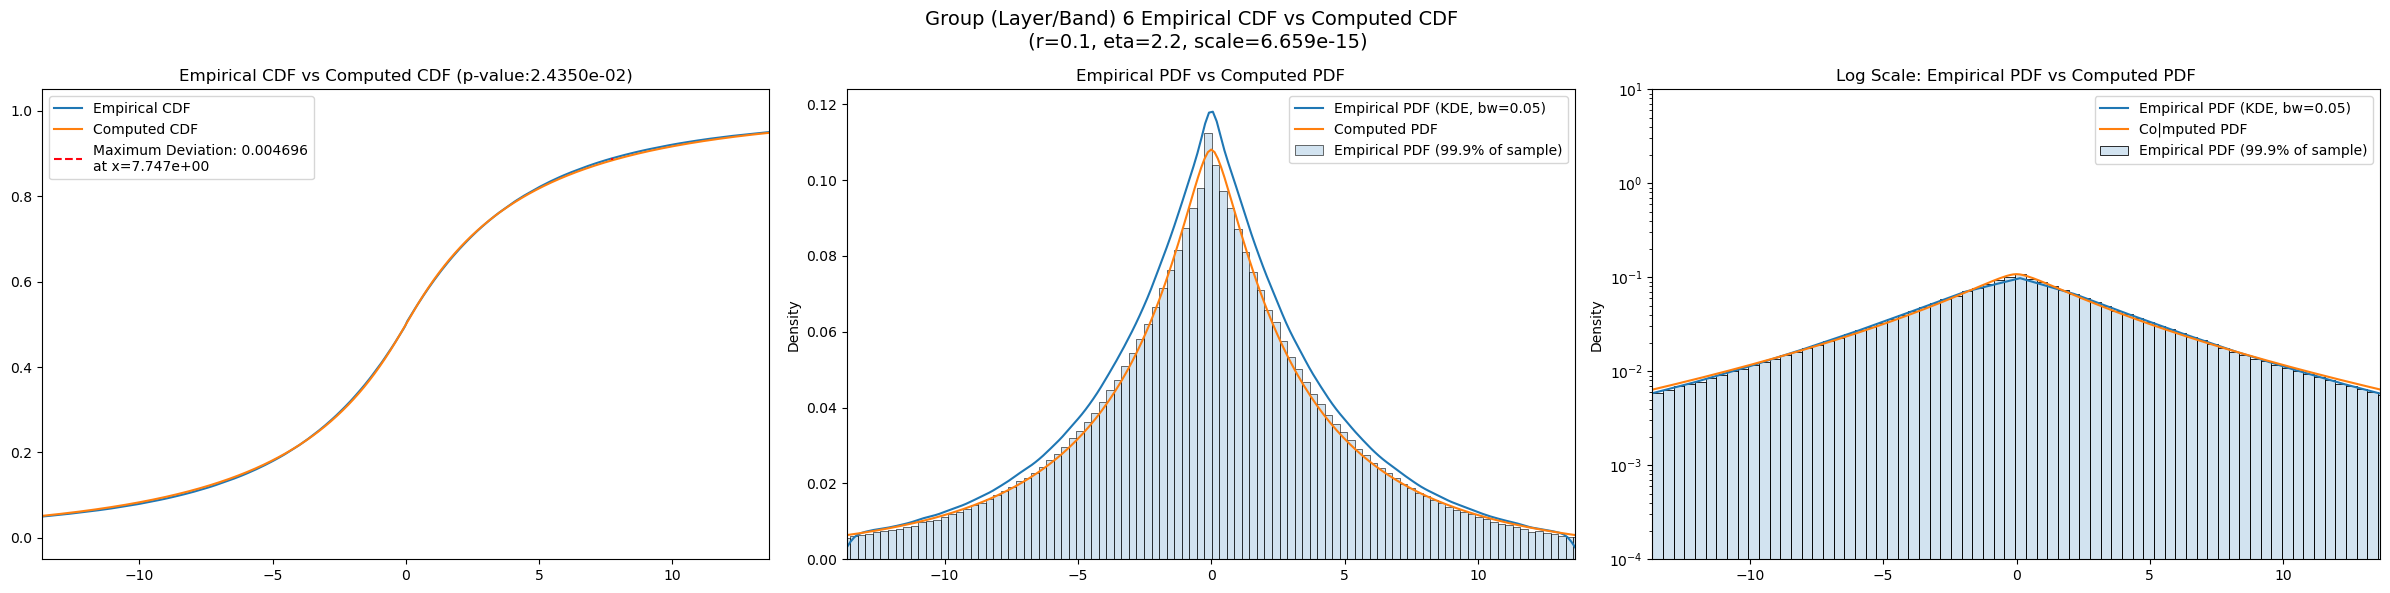

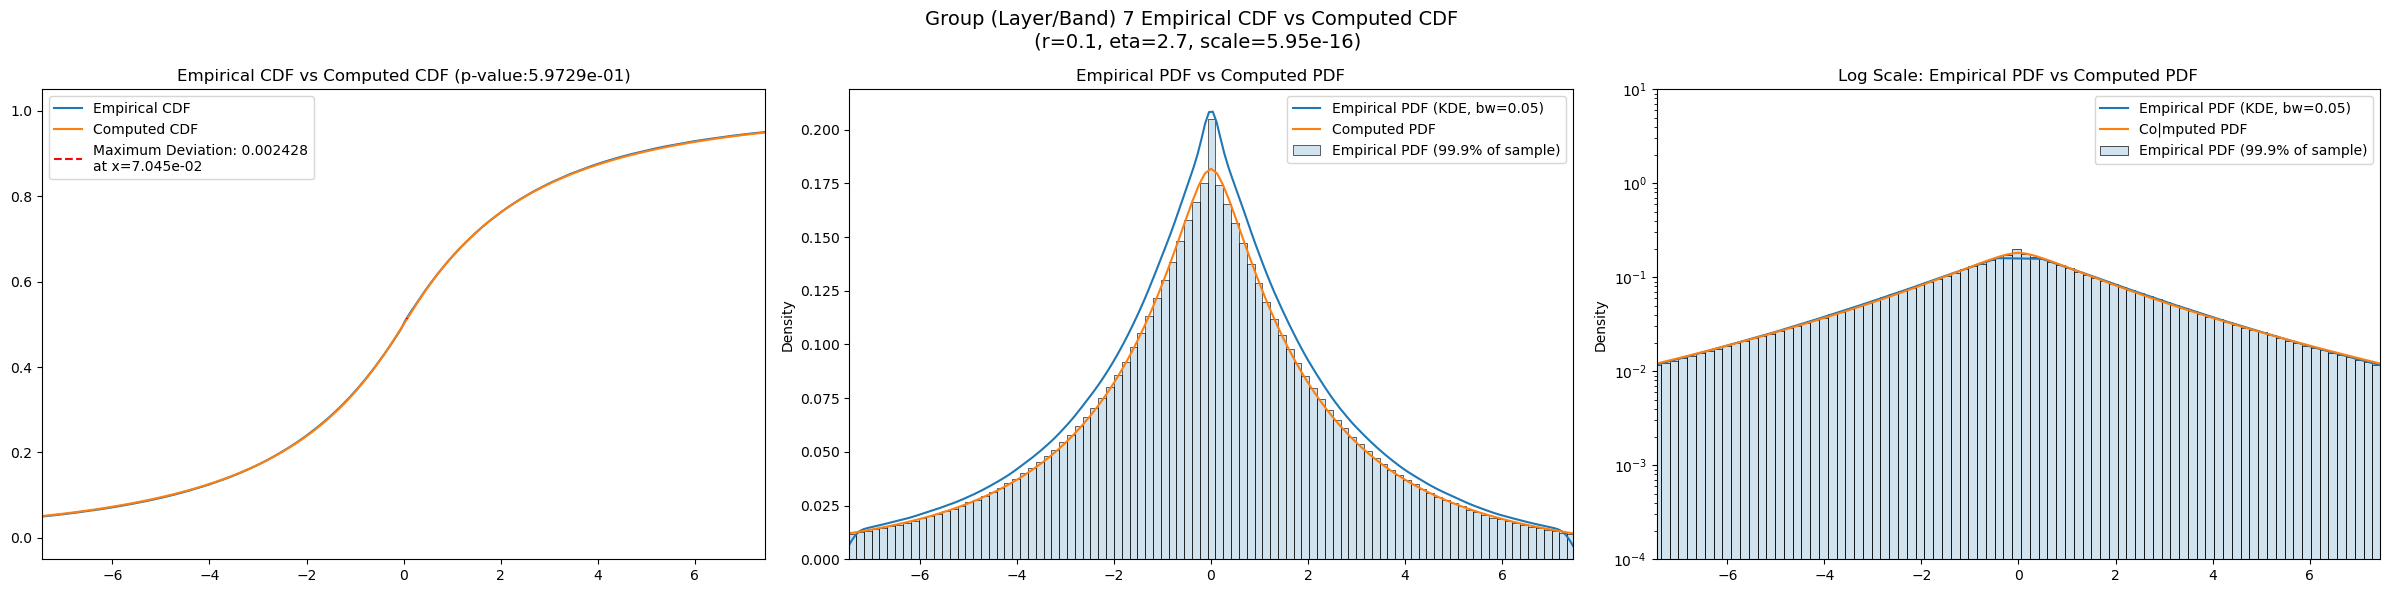

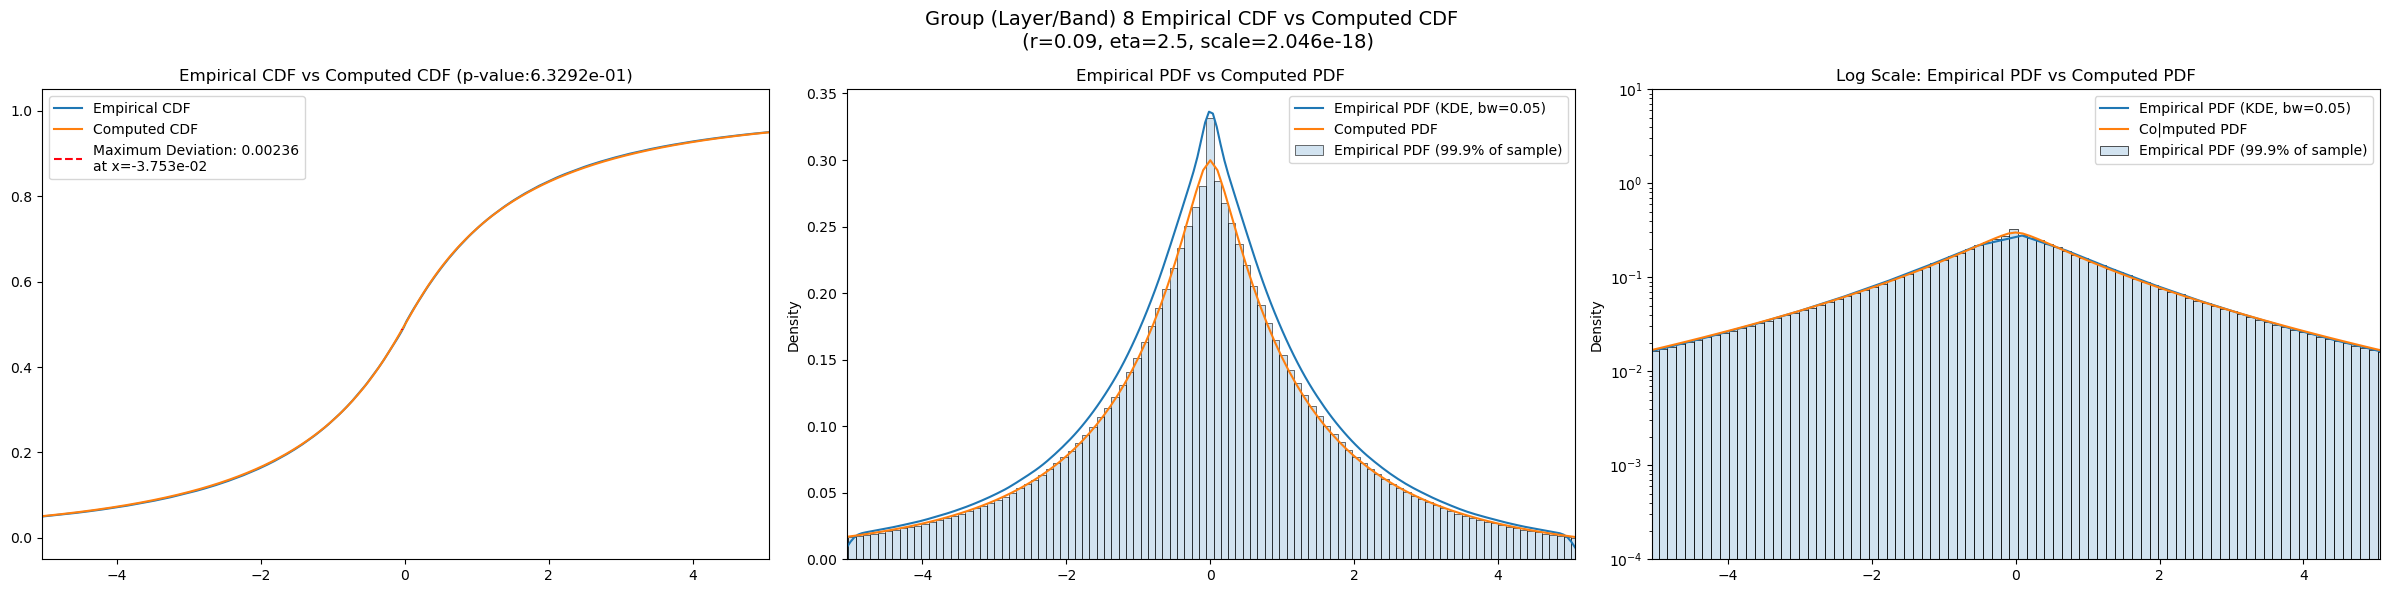

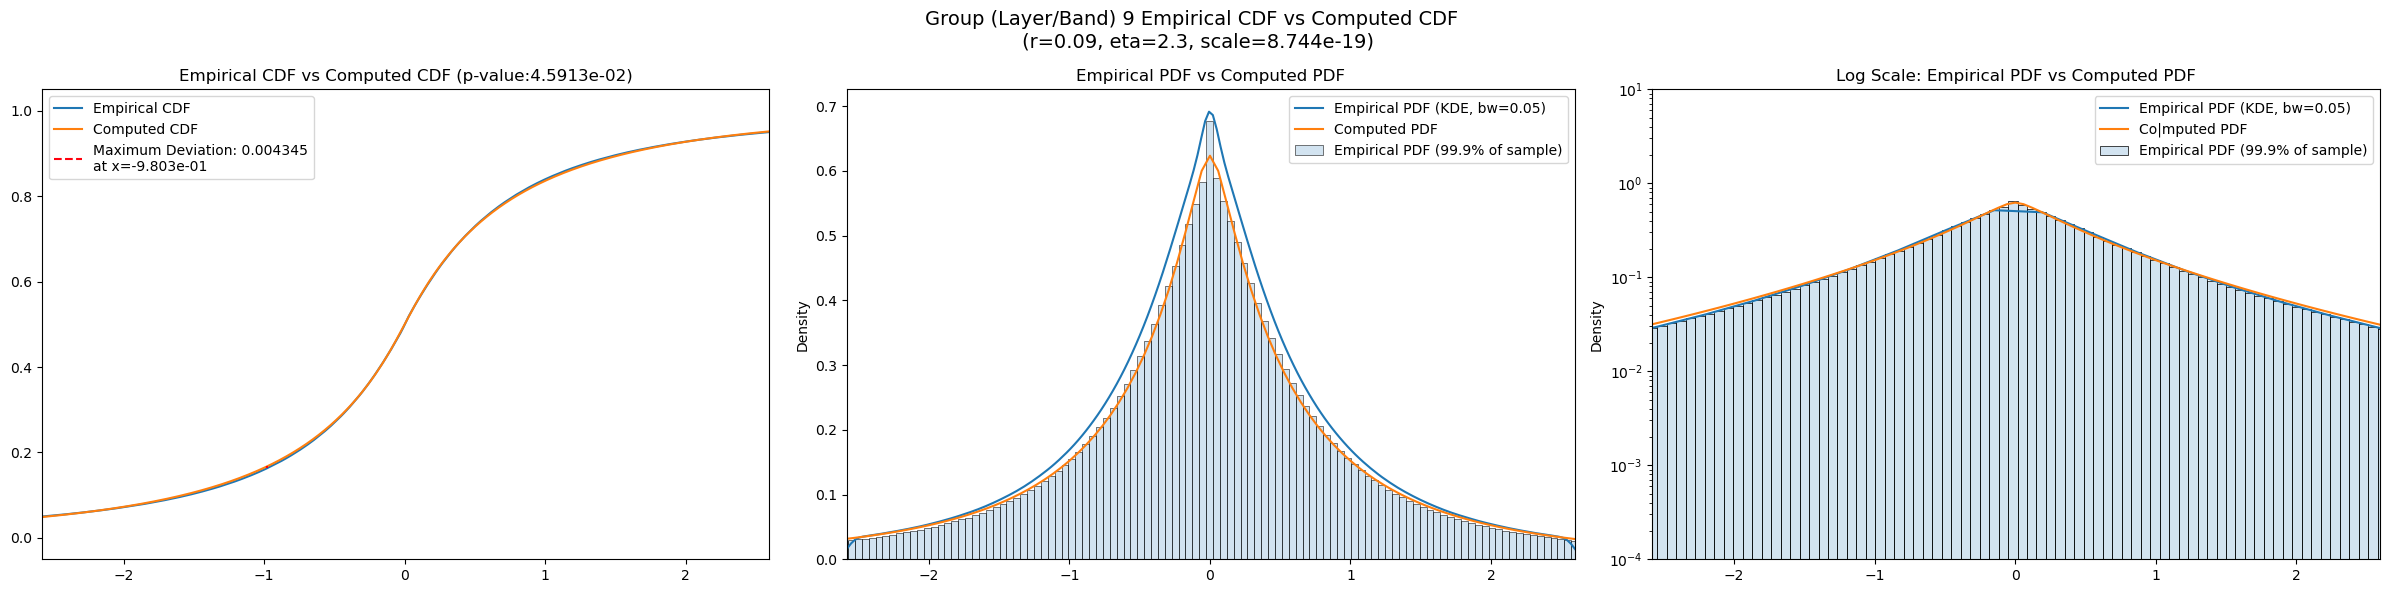

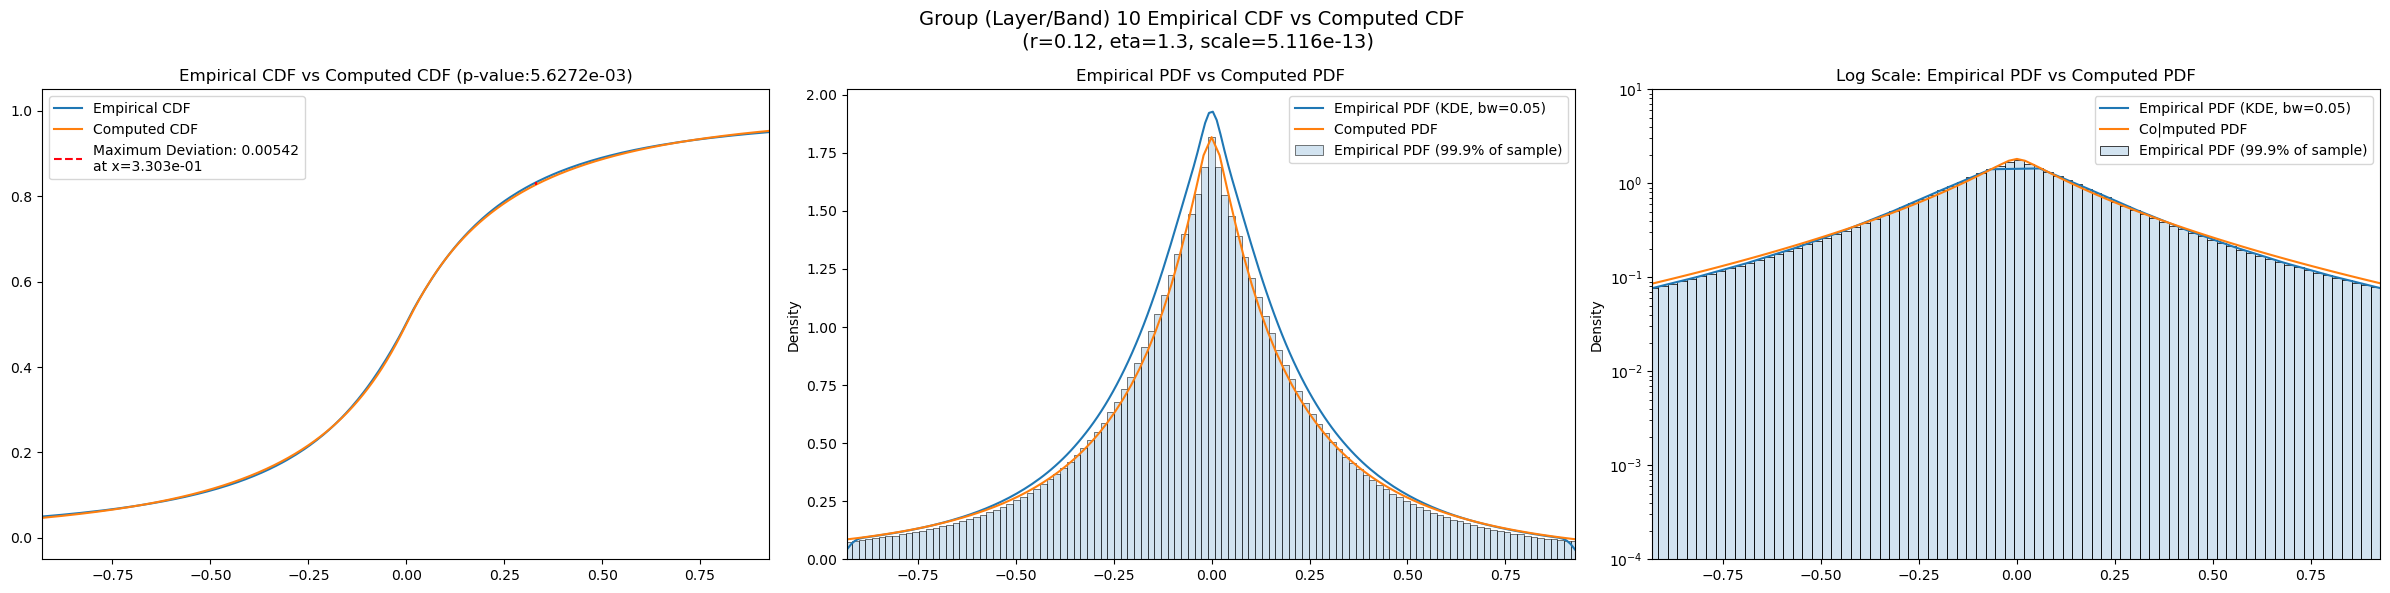

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var      var_lower      var_upper   obs_kurt  kurt_lower  \
layer                                                                       
2      181299.020000  101527.920000  290782.220000   377.2548   142.30005   
3       38790.293000   21575.710000   67724.600000   543.3528   122.41325   
4        9777.153000    4939.129400   17951.637000   703.4225   122.04025   
5        1796.309800     838.055700    4289.687500  1421.5957    90.04052   
6         385.143370     175.531220    1132.569200  2320.8230    86.76239   
7         101.085400      41.345040     424.742130  4763.6500    67.00212   
8          34.403240      17.919370      89.392410  1599.7200    74.53908   
9           9.890553       5.271057      25.139685  1503.5704    80.86954   
10          1.437362       0.713616       4.495828  2671.0093    76.31533   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       530.95166           9000             0.013793        0.1          2.7   
3      1044.59230          36000             0.009006        0.1          1.8   
4      1327.85640         144000             0.007005        0.1          1.4   
5      3420.66140         576000             0.005905        0.1          1.6   
6      4401.83100        2304000             0.004298        0.1          2.2   
7      6338.22100        9216000             0.003062        0.1          2.6   
8      3571.94240       36864000             0.002504        0.1          2.1   
9      3415.08840      147456000             0.004429        0.1          2.0   
10     4559.32400      589824000             0.006147        0.1          1.7   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...      133.283000              0.051487          3.560480e-21   
3      ...       54.470200              0.053977          1.326960e-91   
4      ...       23.807300              0.051987          0.000000e+00   
5      ...       11.066500              0.047423          0.000000e+00   
6      ...        5.830960              0.041876          0.000000e+00   
7      ...        3.282310              0.039788          0.000000e+00   
8      ...        2.116680              0.044135          0.000000e+00   
9      ...        1.039990              0.046768          0.000000e+00   
10     ...        0.364664              0.047987          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2         118.088000             0.025251         2.035550e-05  92.991800   
3          48.339700             0.027858         1.053390e-24  37.994400   
4          21.203900             0.026668         2.126390e-89  16.520200   
5           9.867960             0.022572        2.311280e-255   7.746950   
6           5.191910             0.016800         0.000000e+00   4.080300   
7           2.906830             0.013691         0.000000e+00   2.314600   
8           1.871250             0.017587         0.000000e+00   1.484420   
9           0.924015             0.021088         0.000000e+00   0.727340   
10          0.324797             0.022723         0.000000e+00   0.254594   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.023652   8.330100e-05          6.453360e-02  
3           0.024763   1.307470e-19          7.867658e-03  
4           0.022996   1.398950e-66          3.519882e-06  
5           0.017730  1.032070e-157          7.166895e-18  
6           0.013522   0.000000e+00          2.170698e-37  
7           0.012877   0.000000e+00          1.016798e-61  
8           0.016131   0.000000e+00         9.625236e-176  
9           0.017751   0.000000e+00          0.000000e+00  
10        

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.013793                 0.014297          0.013793   
3                 0.009006                 0.007153          0.008766   
4                 0.007005                 0.003578          0.006782   
5                 0.005905                 0.001789          0.005905   
6                 0.004298                 0.000895          0.004298   
7                 0.003062                 0.000447          0.002767   
8                 0.002504                 0.000224          0.002340   
9                 0.004429                 0.000112          0.004009   
10                0.006147                 0.000056          0.005831   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.051487             0.025251       0.023652  
3                  0.053977             0.027858       0.024763  
4                  0.051987             0.026668       0.022996  
5                  0.047423             0.022572       0.017730  
6                  0.041876             0.016800       0.013522  
7                  0.039788             0.013691       0.012877  
8                  0.044135             0.017587       0.016131  
9                  0.046768             0.021088       0.017751  
10                 0.047987             0.022723       0.018661

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2            45005.016000          0.013793    0.10       2.7  9.706101e-13   
3            10663.847656          0.008766    0.09       2.0  6.112735e-15   
4             2243.477051          0.006782    0.09       1.7  3.105285e-15   
5              429.701480          0.005905    0.10       1.6  1.396953e-13   
6               98.497536          0.004298    0.10       2.2  6.658721e-15   
7               27.586803          0.002767    0.10       2.7  5.949566e-16   
8               13.485414          0.002340    0.09       2.5  2.046462e-18   
9                3.450860          0.004009    0.09       2.3  8.743537e-19   
10               0.419435          0.005831    0.12       1.3  5.115524e-13   

       best_exclude_cutoff  
layer                       
2                     50.0  
3                    125.0  
4                    325.0  
5                    300.0  
6                    250.0  
7                    175.0  
8                    100.0  
9                    175.0  
10                   275.0

In [21]:
eng.quit()